# Versuchen sie den **Niederschlag** und die **Temperatur** in Straubing vorherzusagen (Prognosehorizont 3 Tage).

**Imports**

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
import statistics
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import r2_score
from math import sqrt
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

# 1. Datenaufbereitung
---

In [ ]:
url_1 = 'https://raw.githubusercontent.com/Nilo-03/ML_project/main/Wettervorhersage/Wettervorhersage/Straubing.csv'     #Datensätze laden
url_2 = 'https://raw.githubusercontent.com/Nilo-03/ML_project/main/Wettervorhersage/Wettervorhersage/Schorndorf.csv'
url_3 = 'https://raw.githubusercontent.com/Nilo-03/ML_project/main/Wettervorhersage/Wettervorhersage/Arber.csv'

straubing_df = pd.read_csv(url_1, sep=',', on_bad_lines='skip', skipinitialspace=True).replace(-999,None)     #fehlende Werte werden in der csv durch "-999" repräsentiert, ändere das zu Nonr
schorndorf_df = pd.read_csv(url_2, sep=',', on_bad_lines='skip', skipinitialspace=True).replace(-999,None)
arber_df = pd.read_csv(url_3, sep=',', on_bad_lines='skip', skipinitialspace=True).replace(-999,None)

#Die Spalte "DATE" zu einem "dattimelike" Objekt konvertieren und anschließend als Index-Spalte festlegen
straubing_df['DATE'] = pd.to_datetime(straubing_df['DATE'],format='%d.%m.%Y')
schorndorf_df['DATE'] = pd.to_datetime(schorndorf_df['DATE'],format='%d.%m.%Y')
arber_df['DATE'] = pd.to_datetime(arber_df['DATE'],format='%d.%m.%Y')

straubing_df.set_index('DATE',inplace=True)
schorndorf_df.set_index('DATE',inplace=True)
arber_df.set_index('DATE',inplace=True)

straubing_df.columns = [f"{column}_Straubing" for column in straubing_df.columns]           #Spalten des jeweiligen Dataframe umbenennen, damit man sich später auskennt woher die Features stammen
schorndorf_df.columns = [f"{column}_Schorndorf" for column in schorndorf_df.columns]
arber_df.columns =[f"{column}_Arber" for column in arber_df.columns]

Alle Daten in ein DataFrame zusammenfügen. Die Hoffnung ist, dass Features der anderen Datensätze die Wettervorhersage in Straubing von den Algorithmen benutzt werden. Vorteil: mehr Daten

In [ ]:
frames = [straubing_df, schorndorf_df, arber_df]
all_data_df = pd.concat(frames, axis= 1)            #wir verwenden nur Features von Schorndorf und Arber, die eingermaßen relevante Features sind. Der Rest wird gedropt.
all_data_df = all_data_df.drop(["LUFTTEMP_AM_ERDB_MINIMUM_Arber","SCHNEEHOEHE_Arber","SONNENSCHEINDAUER_Arber","WINDSPITZE_MAXIMUM_Arber","WINDGESCHWINDIGKEIT_Arber","QUALITAETS_NIVEAU_Arber","MESS_DATUM_Arber","BEDECKUNGSGRAD_Arber","LUFTDRUCK_STATIONSHOEHE_Arber","REL_FEUCHTE_Arber","MESS_DATUM_Schorndorf","QUALITAETS_NIVEAU_Schorndorf", "BEDECKUNGSGRAD_Schorndorf", "LUFTDRUCK_STATIONSHOEHE_Schorndorf", "REL_FEUCHTE_Schorndorf", "WINDGESCHWINDIGKEIT_Schorndorf","WINDSPITZE_MAXIMUM_Schorndorf","SONNENSCHEINDAUER_Schorndorf","SCHNEEHOEHE_Schorndorf"], axis = 1)

**1.1 Fehlende Daten**

In [ ]:
# Anzahl der fehlenden Werte pro Spalte ermitteln
missing_values = all_data_df.isna().sum()               #Überprüfen, ob Niederschlagswerte fehlen. Dort sollte kein Fordward-Fill angewendet werden
print(f"{missing_values/all_data_df.shape[0]}\n")


MESS_DATUM_Straubing                   0.000000
QUALITAETS_NIVEAU_Straubing            0.289752
LUFTTEMPERATUR_Straubing               0.289752
DAMPFDRUCK_Straubing                   0.290679
BEDECKUNGSGRAD_Straubing               0.291395
LUFTDRUCK_STATIONSHOEHE_Straubing      0.666905
REL_FEUCHTE_Straubing                  0.290679
WINDGESCHWINDIGKEIT_Straubing          0.357483
LUFTTEMPERATUR_MAXIMUM_Straubing       0.289752
LUFTTEMPERATUR_MINIMUM_Straubing       0.289752
LUFTTEMP_AM_ERDB_MINIMUM_Straubing     0.289752
WINDSPITZE_MAXIMUM_Straubing           0.358030
NIEDERSCHLAGSHOEHE_Straubing           0.289752
NIEDERSCHLAGSHOEHE_IND_Straubing       0.289794
SONNENSCHEINDAUER_Straubing            0.289752
SCHNEEHOEHE_Straubing                  0.322227
LUFTTEMPERATUR_Schorndorf              0.697401
DAMPFDRUCK_Schorndorf                  0.697780
LUFTTEMPERATUR_MAXIMUM_Schorndorf      0.697401
LUFTTEMPERATUR_MINIMUM_Schorndorf      0.697401
LUFTTEMP_AM_ERDB_MINIMUM_Schorndorf    0

Es ist zu sehen, dass für die meisten Features viele bzw. der Großteil der Daten fehlt. Bei einem Blick auf die Datensätze fällt hierbei auf, dass für große Zeiträume sämtliche Daten fehlen. Um dem entgegenzuwirken, kann der Datensatz einfach abgeschnitten werden.

<Axes: xlabel='DATE'>

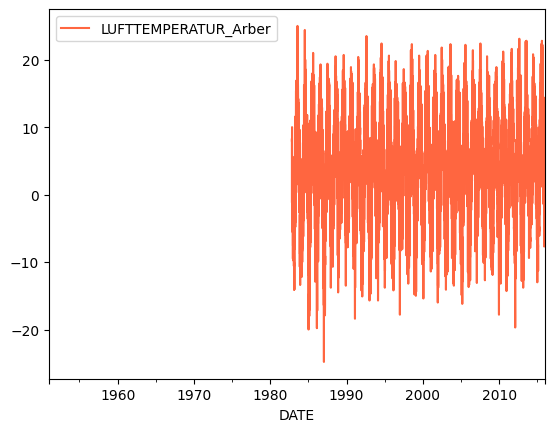

In [ ]:
all_data_df[['LUFTTEMPERATUR_Arber']].plot(color=(1.0, 0.4, 0.25))

<Axes: xlabel='DATE'>

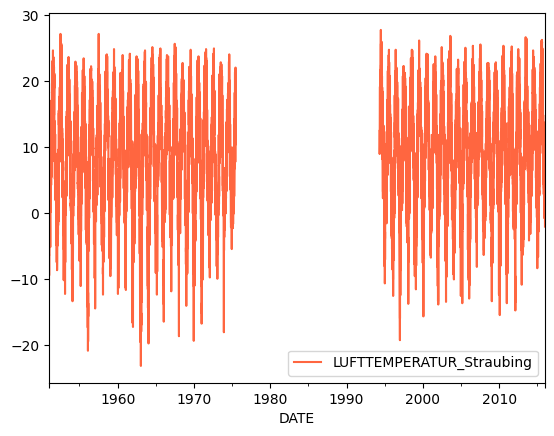

In [ ]:
all_data_df[['LUFTTEMPERATUR_Straubing']].plot(color=(1.0, 0.4, 0.25))

<Axes: xlabel='DATE'>

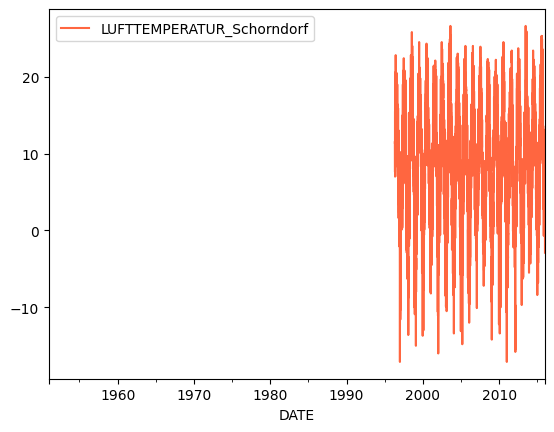

In [ ]:
all_data_df[['LUFTTEMPERATUR_Schorndorf']].plot(color=(1.0, 0.4, 0.25))

In [ ]:
all_data_df['LUFTTEMPERATUR_Schorndorf'].loc['1996-04-30':]

DATE
1996-04-30    None
1996-05-01    11.4
1996-05-02    11.6
1996-05-03     9.6
1996-05-04     8.6
              ... 
2015-12-27     3.0
2015-12-28    -0.1
2015-12-29     1.5
2015-12-30     1.6
2015-12-31    -2.9
Freq: D, Name: LUFTTEMPERATUR_Schorndorf, Length: 7185, dtype: object

Für Schorndorf fehlen also sämtliche Daten vor 1996.05.01, somit kann der Datensatz vor diesem Datum abgeschnitten werden.

In [ ]:
all_data_df = all_data_df.drop(all_data_df[(all_data_df.index < '1996-05-01')].index)
missing_values = all_data_df.isna().sum()               #Überprüfen, ob Niederschlagswerte fehlen. Dort sollte kein Fordward-Fill angewendet werden
print(f"{missing_values/all_data_df.shape[0]}\n")

MESS_DATUM_Straubing                   0.000000
QUALITAETS_NIVEAU_Straubing            0.000000
LUFTTEMPERATUR_Straubing               0.000000
DAMPFDRUCK_Straubing                   0.003062
BEDECKUNGSGRAD_Straubing               0.005429
LUFTDRUCK_STATIONSHOEHE_Straubing      0.000835
REL_FEUCHTE_Straubing                  0.003062
WINDGESCHWINDIGKEIT_Straubing          0.003202
LUFTTEMPERATUR_MAXIMUM_Straubing       0.000000
LUFTTEMPERATUR_MINIMUM_Straubing       0.000000
LUFTTEMP_AM_ERDB_MINIMUM_Straubing     0.000000
WINDSPITZE_MAXIMUM_Straubing           0.002923
NIEDERSCHLAGSHOEHE_Straubing           0.000000
NIEDERSCHLAGSHOEHE_IND_Straubing       0.000139
SONNENSCHEINDAUER_Straubing            0.000000
SCHNEEHOEHE_Straubing                  0.107322
LUFTTEMPERATUR_Schorndorf              0.000000
DAMPFDRUCK_Schorndorf                  0.001253
LUFTTEMPERATUR_MAXIMUM_Schorndorf      0.000000
LUFTTEMPERATUR_MINIMUM_Schorndorf      0.000000
LUFTTEMP_AM_ERDB_MINIMUM_Schorndorf    0

Das sieht doch schon viel besser aus, die übrigen fehlenden Daten können nun einfach aufgefüllt werden.

**Wie wird mit den fehlenden Daten umgegangen?**

1.   Fehlen die meisten Daten am Anfang oder in eingigen Jahren, dann kann einfach abgeschnitten werden
2.   Fehlt der Großteil bzw. fast alle Datenpunkte eines Features, dann kann dieses einfach ignoriert werden
3.   Fehlen nur vereinzelt Daten und hierzu auch noch unregelmäßig, dann kann beispielsweise mit dem Mittelwert (aus Monat oder Tag) oder auch mit dem Ziehen aus einer Zufallsverteilung gearbeitet werden
4.   Fehlen allerdings systematisch Daten aus z.B. dem Sommer, dann muss eine andere Lösung gefunden werden



Aus den beiden Plots folt, dass für die Jahre 1976 bis 1993 sämtliche Daten und für  1975 sowie 1994 rund die Hälfte der Daten für Lufttemperatur und Niederschlagshöhe fehlen. Das gleiche gilt auch für andere Features im selben Zeitraum. Bei genauerem Analysieren ist festzustellen, dass für die Schneehöhe Daten ab dem Juli 1975 bis genau Anfang Mai 1994 fehlen. Dieser Zeitraum kann also aus dem Datensatz entfernt werden, da er nicht zu gebrauchen ist.<br>**ACHTUNG: Sollte das wirklich einfach so gemacht werden, dies beinträchtigt die Performance des Modells**<br>

*   Daten aus Schorndorf miteinbeziehen (Update: geht nicht, Schorndorf hat erst Daten ab ca. 1996)
*   Daten bis 1996 komplett abschneiden?
*   Daten anderweitig auffüllen



**Jahre mit fehlenden Daten entfernen**<br> Sollte das einfach so gemacht werden? Die Daten gehen nicht natlos ineinander über, müsste dann also ein Übergang zwischen den Tagen hergestellt werden, oder sollte die Daten doch besser aufgefüllt werden? **Deshalb werden hier semtliche Daten vor Main 1994 abgeschnitten**

Das sieht schon viel besser aus, sieht also danach aus, dass der zuvor bestimmte Zeitraum den Großteil der fehlenden Datenpunkte ausmachte. In einigen Spalten fehlt noch ein Anteil an Daten, welcher im niedrigen einstelligen Prozentbereich liegt, diese könnte möglicherweise mit "Forward-Fill" aufgefüllt werden.

In [ ]:
#Um das systematische Fehlen von Daten zu erkennen kann man eine Liste an allen Monaten
#erstellen und jeweils das Auftreten von "None" für jedes Feature zählen.
#none_in_year = pd.DataFrame(index=range(1,straubing_df.shape[0]+1),columns=[col for col in straubing_df.columns if (col!='DATE' and col!='MESS_DATUM')])


none_in_month = pd.DataFrame(0, index=range(1, 13), columns=[col for col in all_data_df.columns if col not in ['MESS_DATUM']])
none_in_year = pd.DataFrame(0, index=range(1951, 2016), columns=[col for col in all_data_df.columns if col not in ['MESS_DATUM']])

for feature in none_in_month.columns:
    for month in range(1, 13):
        sublet = [x for x in all_data_df.loc[all_data_df.index.month == month, feature] if pd.isna(x)]
        none_in_month[feature].loc[month] += len(sublet)

for feature in none_in_year.columns:
    for year in range(1951, 2016):
        sublet = [x for x in all_data_df.loc[all_data_df.index.year == year, feature] if pd.isna(x)]
        none_in_year[feature].loc[year] += len(sublet)


In [ ]:
none_in_month

,MESS_DATUM_Straubing,QUALITAETS_NIVEAU_Straubing,LUFTTEMPERATUR_Straubing,DAMPFDRUCK_Straubing,BEDECKUNGSGRAD_Straubing,LUFTDRUCK_STATIONSHOEHE_Straubing,REL_FEUCHTE_Straubing,WINDGESCHWINDIGKEIT_Straubing,LUFTTEMPERATUR_MAXIMUM_Straubing,LUFTTEMPERATUR_MINIMUM_Straubing,...,LUFTTEMPERATUR_MINIMUM_Schorndorf,LUFTTEMP_AM_ERDB_MINIMUM_Schorndorf,NIEDERSCHLAGSHOEHE_Schorndorf,NIEDERSCHLAGSHOEHE_IND_Schorndorf,LUFTTEMPERATUR_Arber,DAMPFDRUCK_Arber,LUFTTEMPERATUR_MAXIMUM_Arber,LUFTTEMPERATUR_MINIMUM_Arber,NIEDERSCHLAGSHOEHE_Arber,NIEDERSCHLAGSHOEHE_IND_Arber
1,0,0,0,0,0,0,0,2,0,0,...,0,0,0,0,1,0,0,0,0,0
2,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,4,0,4,4,4,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,2,6,0,2,4,0,0,...,0,0,0,0,0,1,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,4,0,0,0,0
6,0,0,0,4,4,0,4,2,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,3,4,0,3,1,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,3,11,0,3,3,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,3,2,0,2,0,0,...,0,0,0,0,0,2,0,0,0,0
10,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


Es ist zu erkennen, das bei den Features, bei denen weiterhin der Großteil der Daten fehlt, ungefähr gleichmäßig Daten über alle Monate hinweg fehlen. Weiterhin liegt bei der Schneehöhe ein systematisches Fehlen von Daten aus den Jahren 2009 bis 2015 vor. <br>Aus dieser Darstellung geht außerdem hervor, dass wahrscheinlich ,mit "Forward_Fill" gerarbeitet werden kann, da für die restlichen features nur unregelmäßig Daten fehlen und die anderen features nicht sonderlich relevant für die Prognose sind.

**Anwendung von "Forward-Fill"** (andere Verfahren wie der Mittelwert aus einem Monat könnten vielleicht besser funktionieren)

In [ ]:
ffill_all_data_df = all_data_df
ffill_features = ['DAMPFDRUCK_Straubing','BEDECKUNGSGRAD_Straubing','REL_FEUCHTE_Straubing','NIEDERSCHLAGSHOEHE_IND_Straubing', 'WINDGESCHWINDIGKEIT_Straubing','WINDSPITZE_MAXIMUM_Straubing','LUFTDRUCK_STATIONSHOEHE_Straubing',"DAMPFDRUCK_Schorndorf", "LUFTTEMPERATUR_Arber", "DAMPFDRUCK_Arber"]
ffill_all_data_df[ffill_features] = ffill_all_data_df[ffill_features].ffill() #füllt alle Datenpunkte, die den Wert None haben, mit der Methode Forward-Fill
ffill_all_data_df['SCHNEEHOEHE_Straubing'] = ffill_all_data_df['SCHNEEHOEHE_Straubing'].fillna(0)  	#füllt die fehlenden Datenpunkte für die Schneehöhe mit Null auf ->Eigentlich nicht relevant wie oben zu sehen ist

In [ ]:
missing_values = ffill_all_data_df.isna().sum()               #Ein letztes Mal :)
print(f"{missing_values/ffill_all_data_df.shape[0]}\n")       #Jetzt fehlen keine Daten mehr

MESS_DATUM_Straubing                   0.0
QUALITAETS_NIVEAU_Straubing            0.0
LUFTTEMPERATUR_Straubing               0.0
DAMPFDRUCK_Straubing                   0.0
BEDECKUNGSGRAD_Straubing               0.0
LUFTDRUCK_STATIONSHOEHE_Straubing      0.0
REL_FEUCHTE_Straubing                  0.0
WINDGESCHWINDIGKEIT_Straubing          0.0
LUFTTEMPERATUR_MAXIMUM_Straubing       0.0
LUFTTEMPERATUR_MINIMUM_Straubing       0.0
LUFTTEMP_AM_ERDB_MINIMUM_Straubing     0.0
WINDSPITZE_MAXIMUM_Straubing           0.0
NIEDERSCHLAGSHOEHE_Straubing           0.0
NIEDERSCHLAGSHOEHE_IND_Straubing       0.0
SONNENSCHEINDAUER_Straubing            0.0
SCHNEEHOEHE_Straubing                  0.0
LUFTTEMPERATUR_Schorndorf              0.0
DAMPFDRUCK_Schorndorf                  0.0
LUFTTEMPERATUR_MAXIMUM_Schorndorf      0.0
LUFTTEMPERATUR_MINIMUM_Schorndorf      0.0
LUFTTEMP_AM_ERDB_MINIMUM_Schorndorf    0.0
NIEDERSCHLAGSHOEHE_Schorndorf          0.0
NIEDERSCHLAGSHOEHE_IND_Schorndorf      0.0
LUFTTEMPERA

Sicherstellen, dass alle Features numerisch sind, damit sie in der Regression verwendet werden können (für Regression Trees oder neuronale Netze ist dies nicht notwendig)

In [ ]:
ffill_all_data_df = ffill_all_data_df.apply(pd.to_numeric)
ffill_all_data_df.dtypes

MESS_DATUM_Straubing                     int64
QUALITAETS_NIVEAU_Straubing              int64
LUFTTEMPERATUR_Straubing               float64
DAMPFDRUCK_Straubing                   float64
BEDECKUNGSGRAD_Straubing               float64
LUFTDRUCK_STATIONSHOEHE_Straubing      float64
REL_FEUCHTE_Straubing                  float64
WINDGESCHWINDIGKEIT_Straubing          float64
LUFTTEMPERATUR_MAXIMUM_Straubing       float64
LUFTTEMPERATUR_MINIMUM_Straubing       float64
LUFTTEMP_AM_ERDB_MINIMUM_Straubing     float64
WINDSPITZE_MAXIMUM_Straubing           float64
NIEDERSCHLAGSHOEHE_Straubing           float64
NIEDERSCHLAGSHOEHE_IND_Straubing         int64
SONNENSCHEINDAUER_Straubing            float64
SCHNEEHOEHE_Straubing                    int64
LUFTTEMPERATUR_Schorndorf              float64
DAMPFDRUCK_Schorndorf                  float64
LUFTTEMPERATUR_MAXIMUM_Schorndorf      float64
LUFTTEMPERATUR_MINIMUM_Schorndorf      float64
LUFTTEMP_AM_ERDB_MINIMUM_Schorndorf    float64
NIEDERSCHLAGS

Die durchschnittliche Temperatur von 7 Tagen wird als zusätzliches Feature hinzugefügt. Dadurch kann man auch beispielsweise saionale Trends besser mit einbeziehen. Der Zeitraum beträgt jedoch die letzten 10 bis 3 Tage vom heutigen Tag. Da für die Vorhersage eine Time Lag von 3 Tagen eingehalten werden muss.

In [ ]:
ffill_all_data_df["LUFTTEMPERATUR_7_TAGE_Straubing"] = ffill_all_data_df["LUFTTEMPERATUR_Straubing"].rolling(window=7,min_periods = 1).mean().shift(3)      #Berechne den Durchschnitt der letzten 7 Tage und schiebe dieses Feature 3 Tage nach unten
ffill_all_data_df["LUFTTEMPERATUR_7_TAGE_Schorndorf"] = ffill_all_data_df["LUFTTEMPERATUR_Schorndorf"].rolling(window=7,min_periods = 1).mean().shift(3)
ffill_all_data_df["LUFTTEMPERATUR_7_TAGE_Arber"] = ffill_all_data_df["LUFTTEMPERATUR_Arber"].rolling(window=7,min_periods = 1).mean().shift(3)

ffill_all_data_df = ffill_all_data_df.dropna()

ffill_all_data_df.head()


,MESS_DATUM_Straubing,QUALITAETS_NIVEAU_Straubing,LUFTTEMPERATUR_Straubing,DAMPFDRUCK_Straubing,BEDECKUNGSGRAD_Straubing,LUFTDRUCK_STATIONSHOEHE_Straubing,REL_FEUCHTE_Straubing,WINDGESCHWINDIGKEIT_Straubing,LUFTTEMPERATUR_MAXIMUM_Straubing,LUFTTEMPERATUR_MINIMUM_Straubing,...,NIEDERSCHLAGSHOEHE_IND_Schorndorf,LUFTTEMPERATUR_Arber,DAMPFDRUCK_Arber,LUFTTEMPERATUR_MAXIMUM_Arber,LUFTTEMPERATUR_MINIMUM_Arber,NIEDERSCHLAGSHOEHE_Arber,NIEDERSCHLAGSHOEHE_IND_Arber,LUFTTEMPERATUR_7_TAGE_Straubing,LUFTTEMPERATUR_7_TAGE_Schorndorf,LUFTTEMPERATUR_7_TAGE_Arber
DATE,,,,,,,,,,,,,,,,,,,,,
1996-05-04,19960504,10,10.5,7.8,6.7,969.8,61.0,3.8,15.0,5.3,...,6,0.4,6.3,2.6,-0.2,4.1,8.0,12.400000,11.400000,6.100000
1996-05-05,19960505,10,10.4,7.2,3.3,973.8,58.0,1.5,15.9,4.0,...,0,3.2,4.4,7.1,-2.8,0.0,0.0,13.100000,11.500000,7.150000
1996-05-06,19960506,10,14.2,8.9,2.0,970.1,55.0,1.4,21.8,3.4,...,0,7.8,7.9,12.5,3.3,0.0,0.0,12.033333,10.866667,5.566667
1996-05-07,19960507,10,17.7,11.5,3.7,968.3,58.0,2.6,23.6,5.9,...,0,10.2,8.9,13.4,7.1,0.0,6.0,11.650000,10.300000,4.275000
1996-05-08,19960508,10,14.5,13.2,6.3,968.9,80.0,2.8,18.6,10.4,...,6,8.5,10.3,10.5,5.6,0.1,6.0,11.400000,9.760000,4.060000


Jetzt ist der Datensatz vollständig!

**Target Werte hinzufügen**


Um die Target Werte hinzuzufügen muss man lediglich die Lufttemperatur und den Niederschlag um 3 Zeilen nach oben verschieben, da die Daten bereits nach Datum sortiert sind.
Wir fügen zusätzlich Target Spalten für Tag 1 und Tag 2 hinzu um später die Performance des Modells über einen Verlauf von 3 Tagen zeigen zu können.


In [ ]:
ffill_all_data_df['LUFTTEMPERATUR_TARGET_TAG_1'] = ffill_all_data_df['LUFTTEMPERATUR_Straubing'].shift(-1)
ffill_all_data_df['LUFTTEMPERATUR_TARGET_TAG_2'] = ffill_all_data_df['LUFTTEMPERATUR_Straubing'].shift(-2)
ffill_all_data_df['LUFTTEMPERATUR_TARGET_TAG_3'] = ffill_all_data_df['LUFTTEMPERATUR_Straubing'].shift(-3)
ffill_all_data_df['NIEDERSCHLAGSHOEHE_TARGET_TAG_1'] = ffill_all_data_df['NIEDERSCHLAGSHOEHE_Straubing'].shift(-1)
ffill_all_data_df['NIEDERSCHLAGSHOEHE_TARGET_TAG_2'] = ffill_all_data_df['NIEDERSCHLAGSHOEHE_Straubing'].shift(-2)
ffill_all_data_df['NIEDERSCHLAGSHOEHE_TARGET_TAG_3'] = ffill_all_data_df['NIEDERSCHLAGSHOEHE_Straubing'].shift(-3)

#letzten drei Tage entfernen, da hierfür keine Targets mehr vorliegt
ffill_all_data_df = ffill_all_data_df.iloc[:-3,:].copy()

# **2. Feature Engineering**


**Heat-Map**<br>


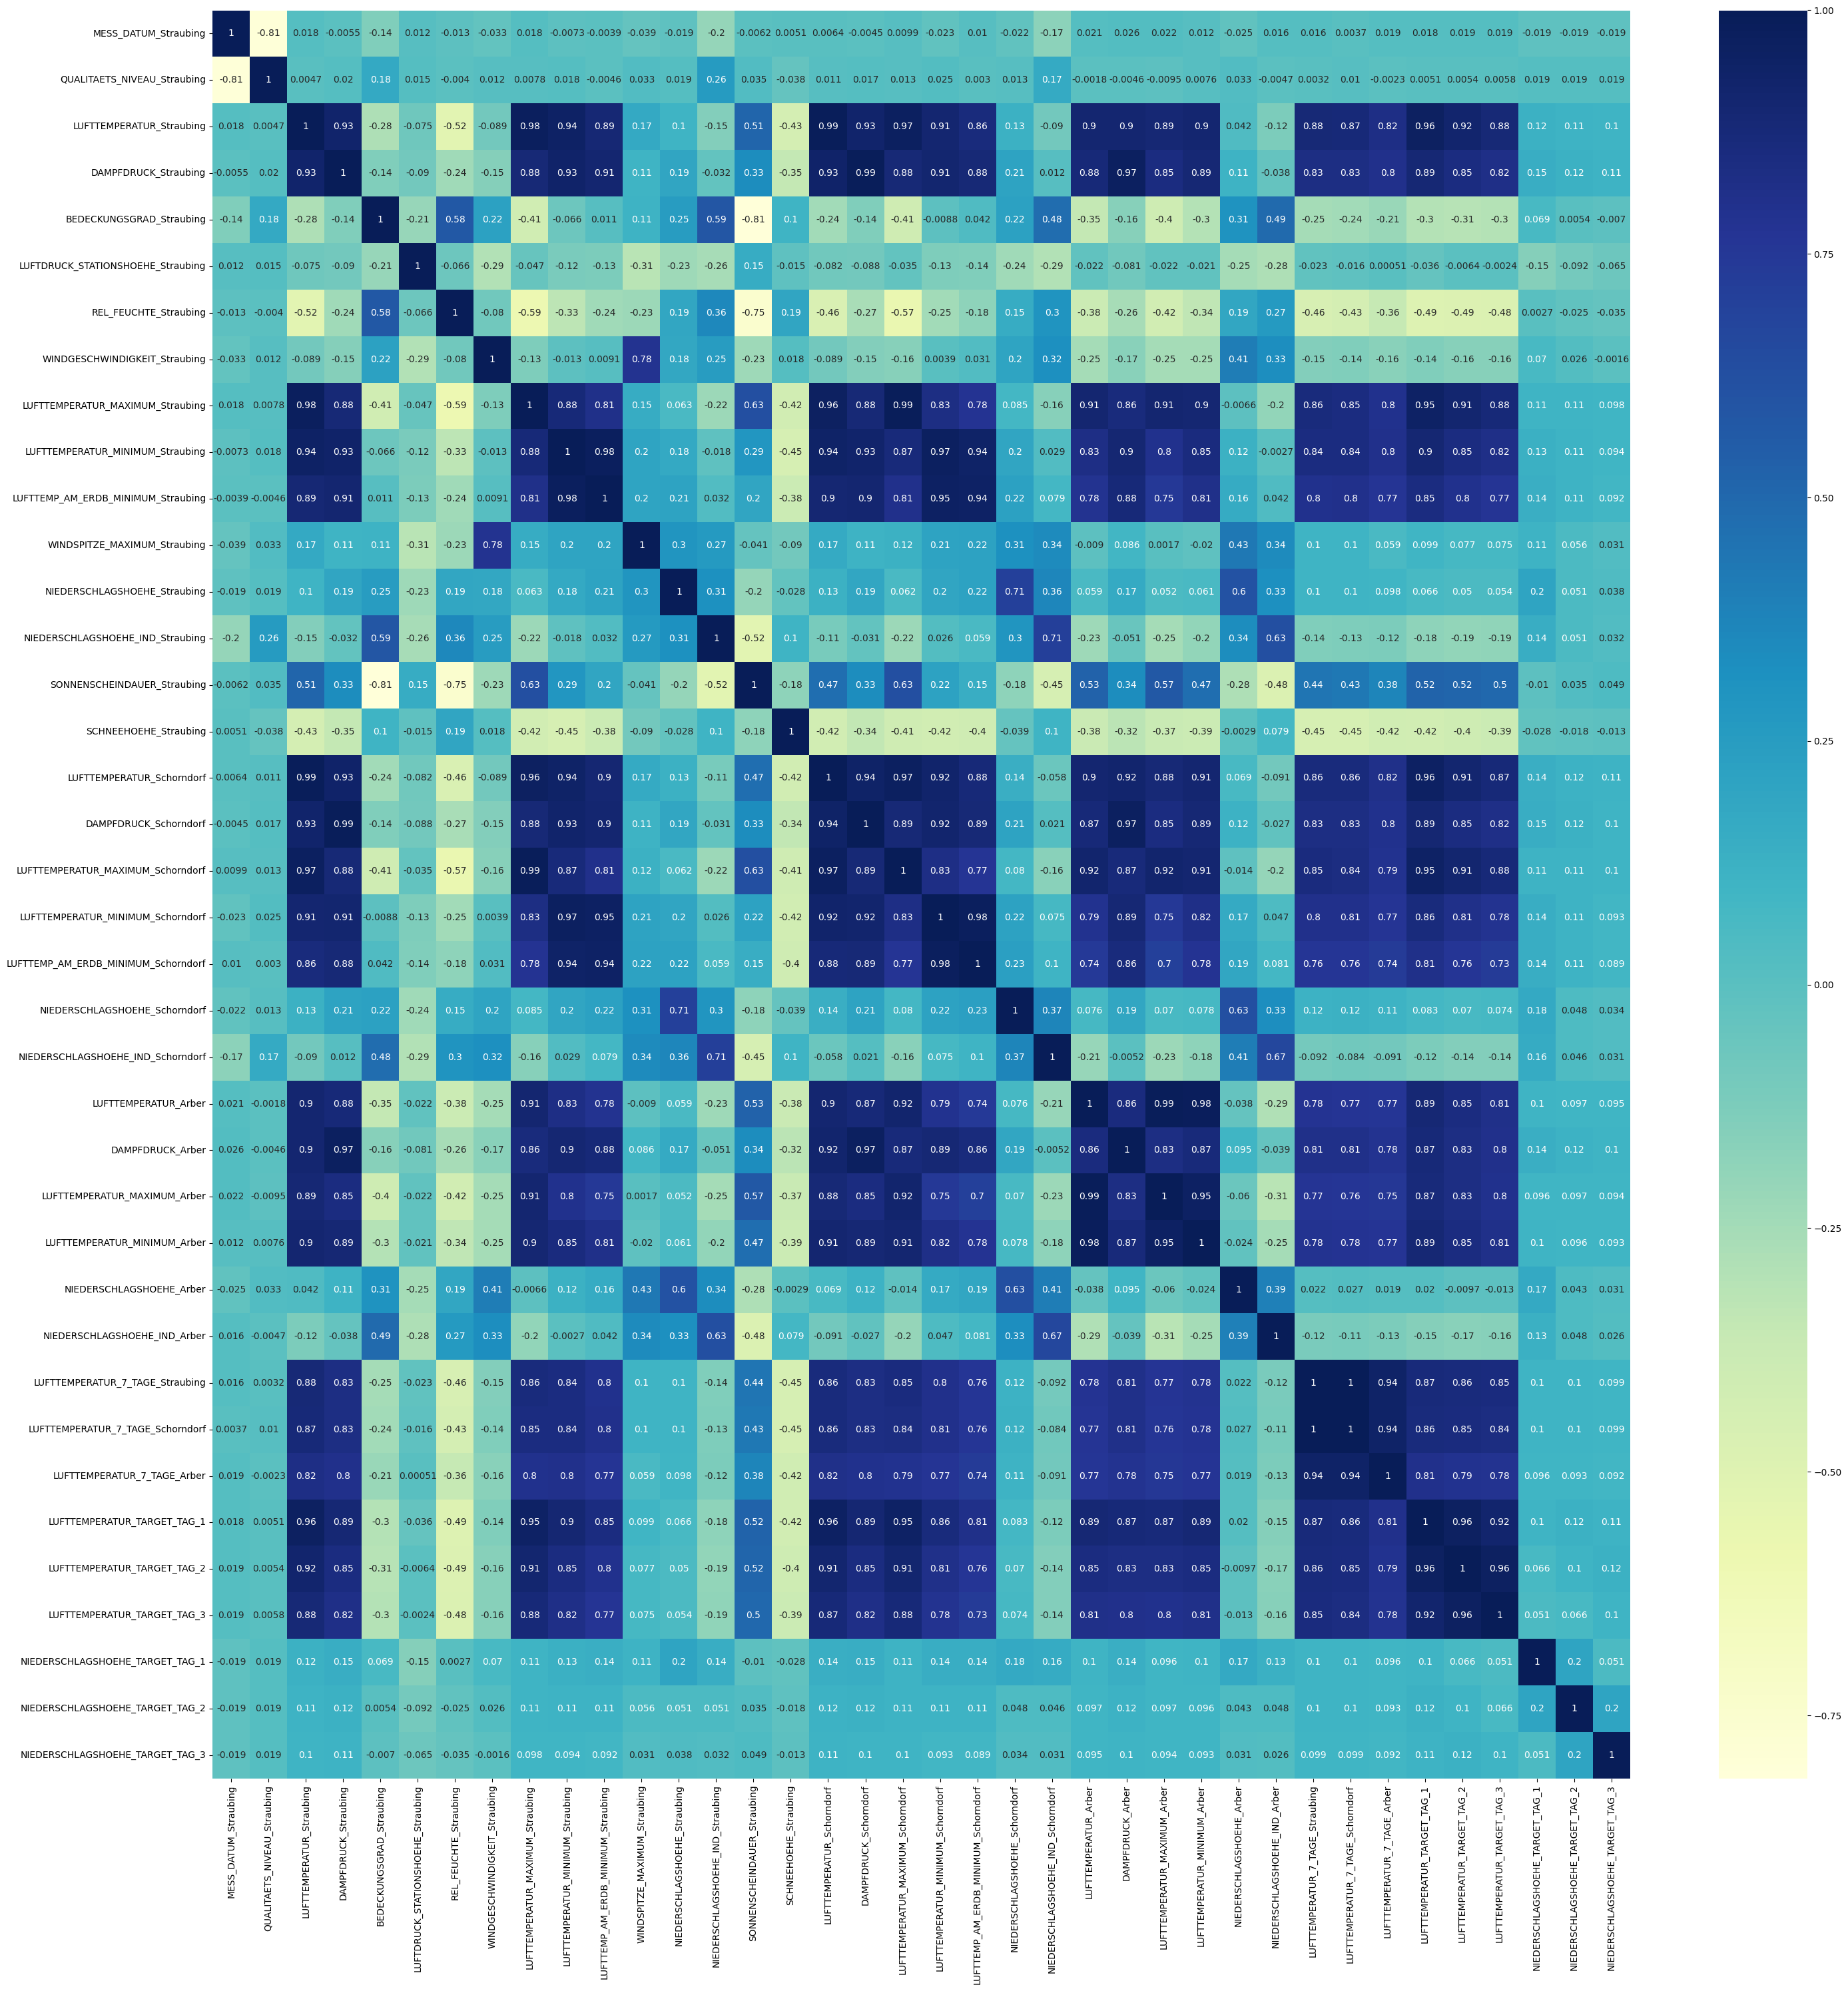

In [ ]:
all_data = ffill_all_data_df
cor = all_data.corr(numeric_only=False)

fig, ax = plt.subplots(figsize=(30,30))
sns.heatmap(cor,cmap="YlGnBu", annot=True, ax=ax)

plt.tight_layout()

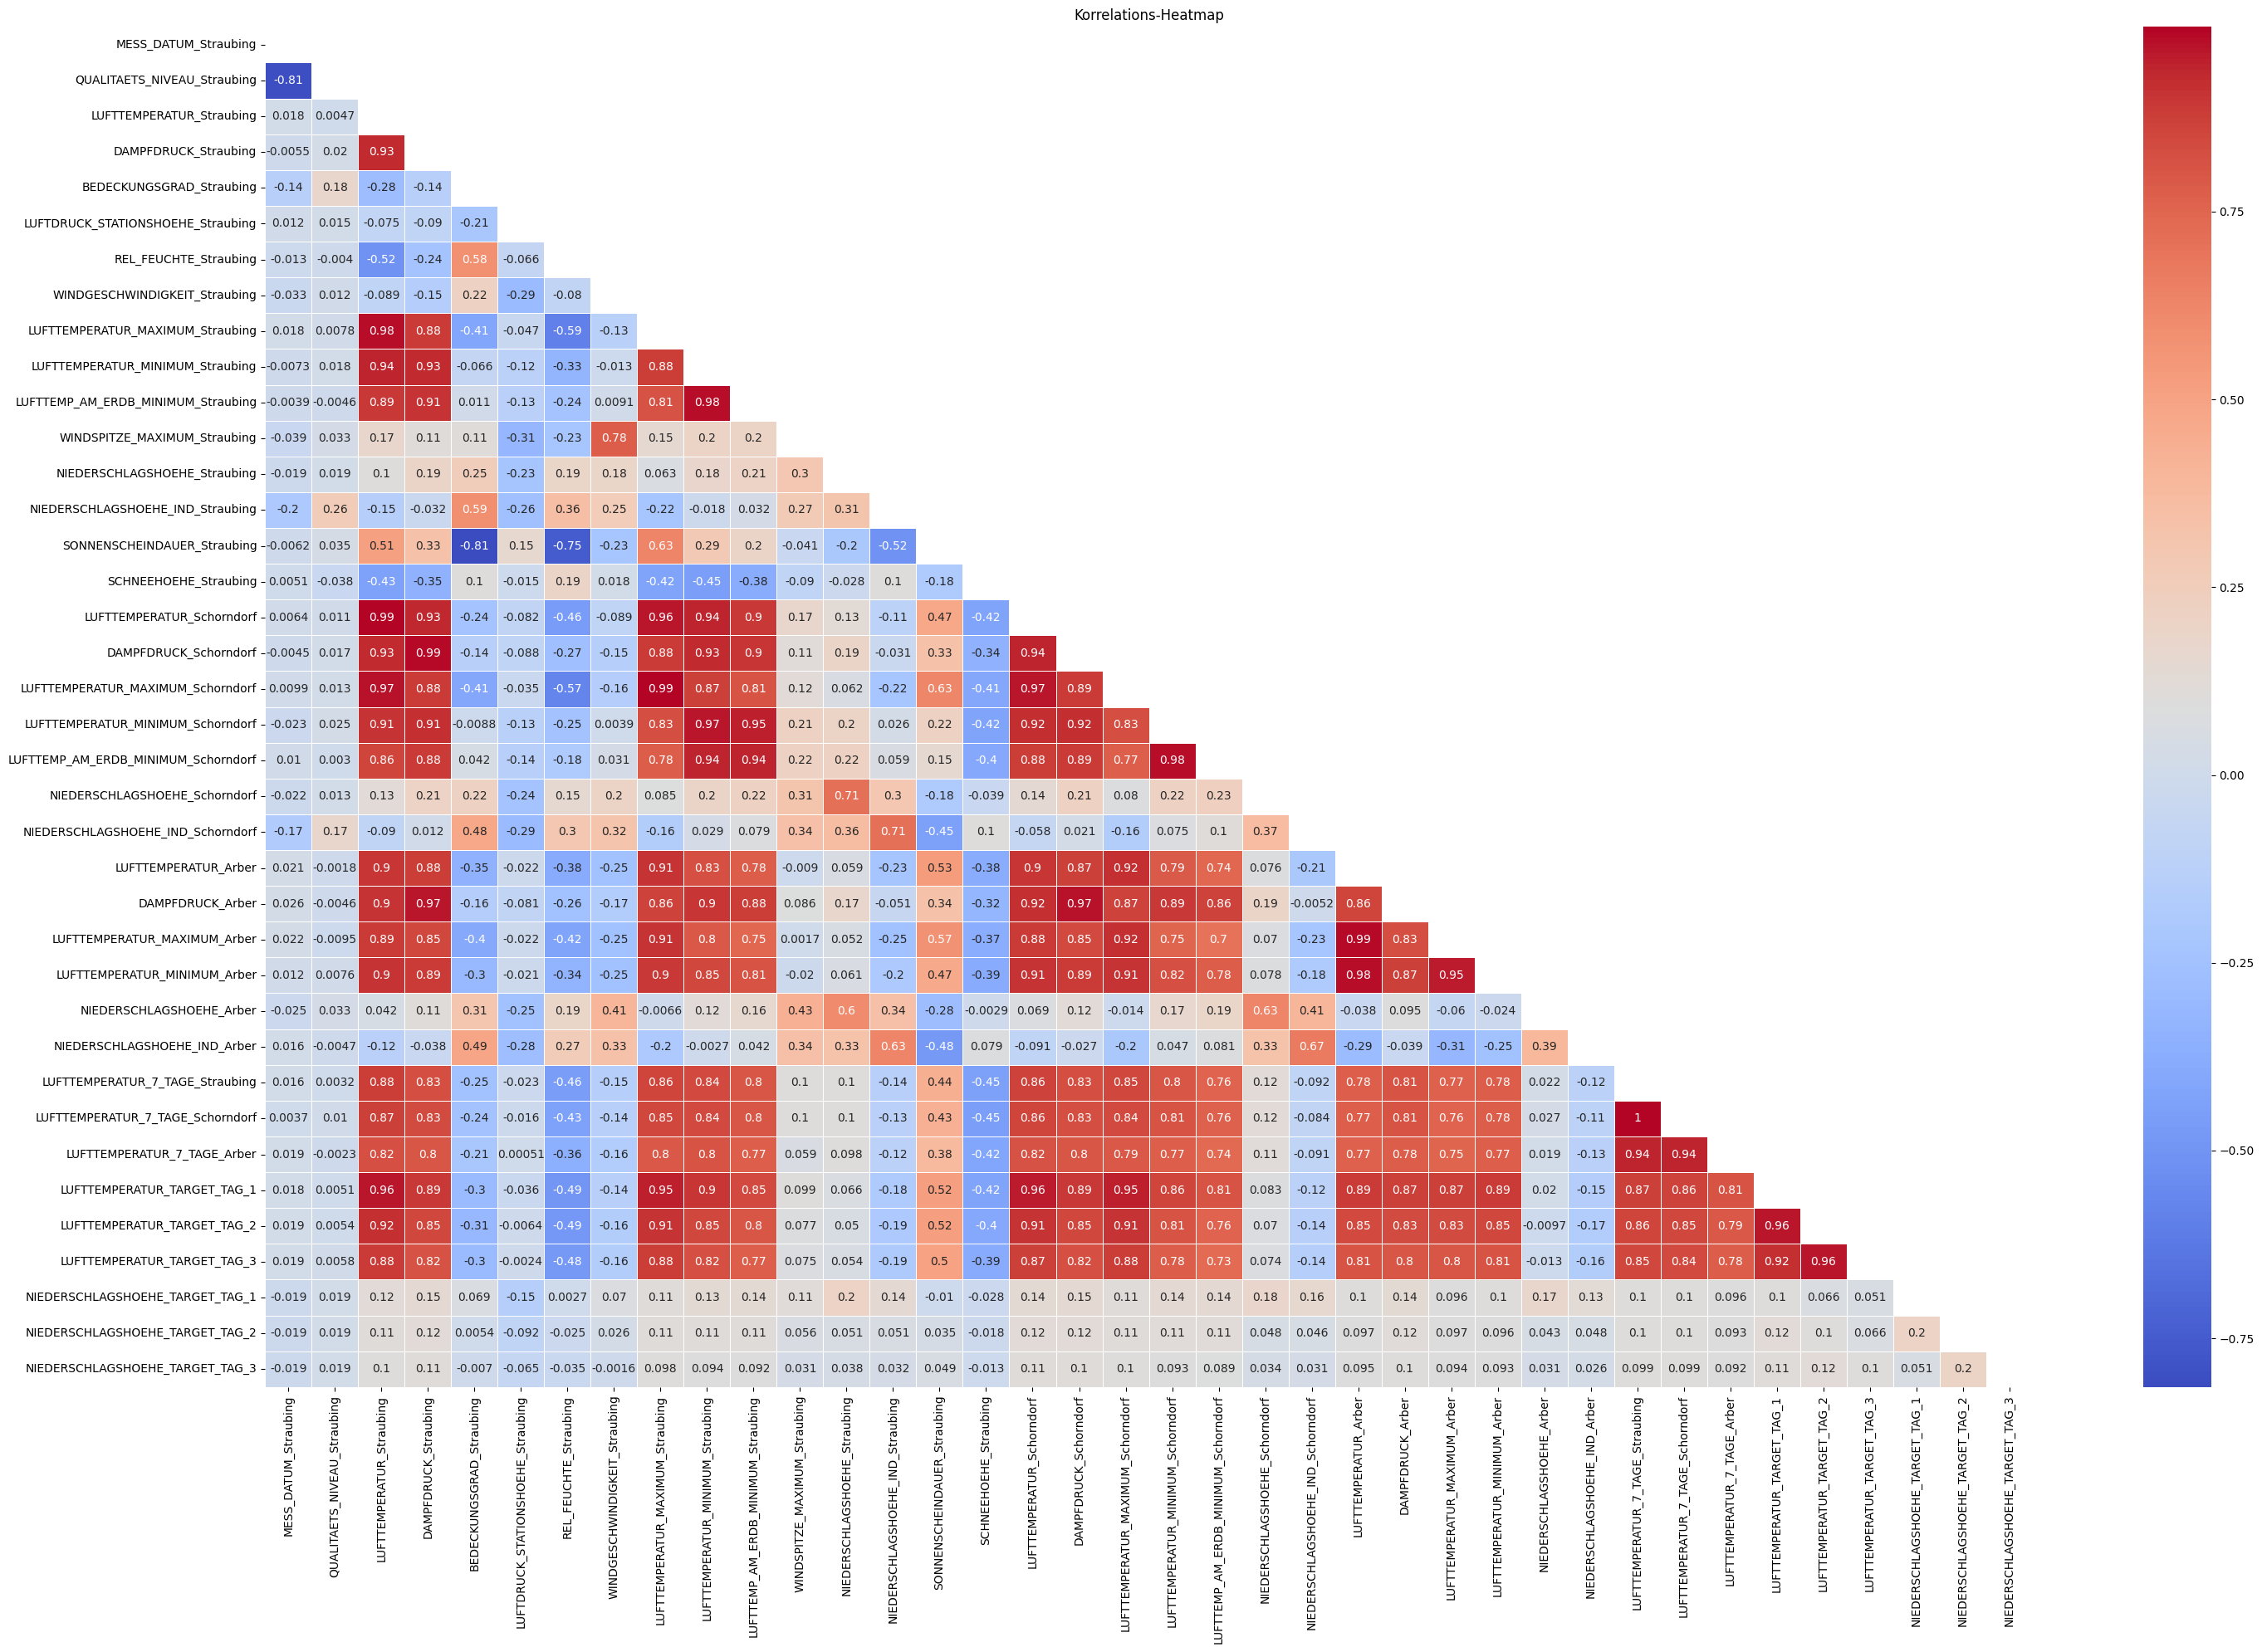

In [ ]:
#alternative Darstellung der Heatmap (Hauptdiagonale und die symmetrischen Daten werden durch Maske entfernt)

# Größe der Heatmap festlegen
plt.figure(figsize=(30, 20))

#mask erstellen: (Eliminierung der Hauptiagonale und darüberliegenden Werten)
mask = np.zeros_like(cor)
mask[np.triu_indices_from(mask)] = True

# Heatmap erstellen
sns.heatmap(cor, annot=True, cmap='coolwarm', linewidths=0.5, mask = mask)
plt.title('Korrelations-Heatmap')

plt.tight_layout()
plt.show()

Man sieht für LUFTTEMPERATUR_TARGET_TAG_3 gibt es mehrere hoch korrelierende Features.
Beim Niederschlag andereseits gibt es kaum korrelierende Features. Das beste hier ist DAMPDRUCK_Straubing mit 0.11. Hier hat man das erste Indiz dafür, dass die Vorhersage für den Niederschlag wohl sehr schlecht ausfallen wird.

**Target features**<br>

1.   Niederschlag
2.   Temperatur



Train test split kann bei dieser Vorhersage nicht verwendet werden, da es sich hier um eine Zeitreihe handelt. Um die Intregrität der Zeitreihe nicht zu zerstören nutzen wir TimeSeriesSplit.

In [ ]:
from sklearn.model_selection import train_test_split

from sklearn.model_selection import TimeSeriesSplit # Splittet Zeitreihen für die Crossvaldation

**Aufteilung der Daten in Features und Targets**

In [ ]:
targets = ["LUFTTEMPERATUR_TARGET_TAG_3"]
#targets = ["NIEDERSCHLAGSHOEHE_TARGET_TAG_3"]



selected_columns = ffill_all_data_df.columns[:-6]     #die letzten 6 Spalten bestehen aus den Target Werten für Niederschlag und Temperatur für Tag 1 bis 3
predictors = selected_columns
predictors

Index(['MESS_DATUM_Straubing', 'QUALITAETS_NIVEAU_Straubing',
       'LUFTTEMPERATUR_Straubing', 'DAMPFDRUCK_Straubing',
       'BEDECKUNGSGRAD_Straubing', 'LUFTDRUCK_STATIONSHOEHE_Straubing',
       'REL_FEUCHTE_Straubing', 'WINDGESCHWINDIGKEIT_Straubing',
       'LUFTTEMPERATUR_MAXIMUM_Straubing', 'LUFTTEMPERATUR_MINIMUM_Straubing',
       'LUFTTEMP_AM_ERDB_MINIMUM_Straubing', 'WINDSPITZE_MAXIMUM_Straubing',
       'NIEDERSCHLAGSHOEHE_Straubing', 'NIEDERSCHLAGSHOEHE_IND_Straubing',
       'SONNENSCHEINDAUER_Straubing', 'SCHNEEHOEHE_Straubing',
       'LUFTTEMPERATUR_Schorndorf', 'DAMPFDRUCK_Schorndorf',
       'LUFTTEMPERATUR_MAXIMUM_Schorndorf',
       'LUFTTEMPERATUR_MINIMUM_Schorndorf',
       'LUFTTEMP_AM_ERDB_MINIMUM_Schorndorf', 'NIEDERSCHLAGSHOEHE_Schorndorf',
       'NIEDERSCHLAGSHOEHE_IND_Schorndorf', 'LUFTTEMPERATUR_Arber',
       'DAMPFDRUCK_Arber', 'LUFTTEMPERATUR_MAXIMUM_Arber',
       'LUFTTEMPERATUR_MINIMUM_Arber', 'NIEDERSCHLAGSHOEHE_Arber',
       'NIEDERSCHLAGSHOEHE

# 3. **Multivariate lineare Regression**

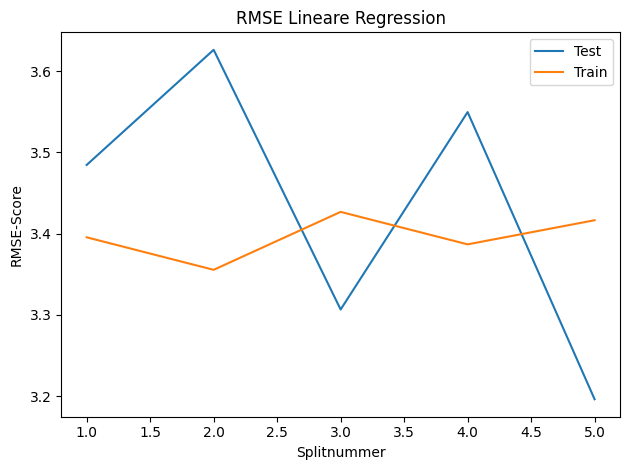

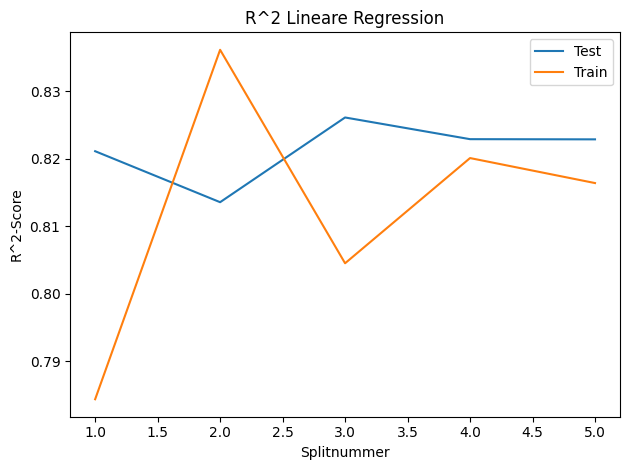

In [ ]:
# Zeitreihen-Kreuzvalidierung
n=5 # extra Variable wird bei allen Regressionsverfahren eingeführt, um den Umgang mit der Anzahl der Splits leichter zu handeln
tscv = TimeSeriesSplit(n_splits=n)

# Leere Listen zum Speichern der Werte initialisieren
rmse_lin_test_list = []
rmse_lin_train_list = []
r2_lin_train_list = []
r2_lin_test_list = []

for train_index, test_index in tscv.split(ffill_all_data_df):

    #Trainings- und Testsplit erstellen
    train, test = ffill_all_data_df.iloc[train_index], ffill_all_data_df.iloc[test_index]

    #Targets festlegen (in unserem Fall Tag 3)
    y_train = train["LUFTTEMPERATUR_TARGET_TAG_3"]
    y_test = test["LUFTTEMPERATUR_TARGET_TAG_3"]

    # Lineares Regressionsmodell initialisieren
    reg_lin = LinearRegression()

    # Modell trainieren
    reg_lin.fit(train[predictors], train[targets])

    # Vorhersagen prognostizieren
    predictions_train = reg_lin.predict(train[predictors])
    predictions_test = reg_lin.predict(test[predictors])

    #RMSE und R^2 berechnen
    rmse_lin_train= sqrt(mean_squared_error(train[targets], predictions_train))
    rmse_lin_test = sqrt(mean_squared_error(test[targets], predictions_test))
    r2_train = r2_score(train[targets], predictions_train)
    r2_test = r2_score(test[targets], predictions_test)

    # RMSE in Liste einfügen
    rmse_lin_train_list.append(rmse_lin_train)
    rmse_lin_test_list.append(rmse_lin_test)

    r2_lin_train_list.append(r2_train)
    r2_lin_test_list.append(r2_test)

#Ausgabe des RMSE-Scores für Training und Test für jeden Split
plt.plot(range(1, n+1), rmse_lin_test_list, label='Test')
plt.plot(range(1, n+1), rmse_lin_train_list, label='Train')
plt.title('RMSE Lineare Regression')
plt.xlabel('Splitnummer')
plt.legend()
plt.ylabel('RMSE-Score')
plt.tight_layout()
plt.show()

plt.plot(range(1, n+1), r2_lin_train_list, label='Test')
plt.plot(range(1, n+1), r2_lin_test_list, label='Train')
plt.title('R^2 Lineare Regression')
plt.xlabel('Splitnummer')
plt.legend()
plt.ylabel('R^2-Score')
plt.tight_layout()
plt.show()

# 3.1 **Ridge Regression**

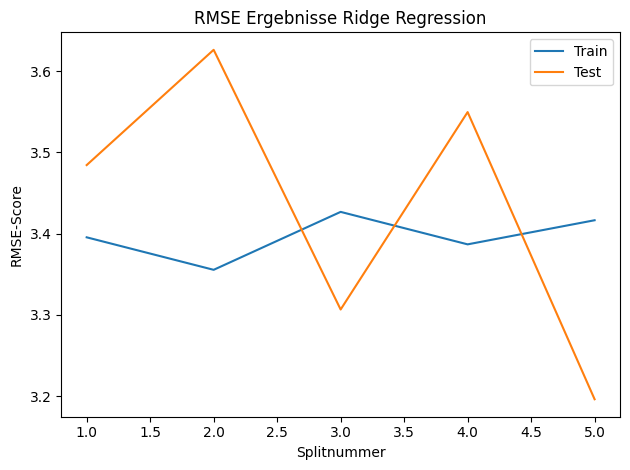

In [ ]:
# Ridge Regression Modell mit Parameter alpha = 0.1 erstellen
reg_ridg = Ridge(alpha=0.3)

# Initialisiere Listen um RMSE-Werte speichern zu können
rmse_ridg_list_train = []
rmse_ridg_list_test = []

# TimeSeriesSplit für Crossvalidation
n = 5
tscv = TimeSeriesSplit(n_splits=n)

for train_index, test_index in tscv.split(ffill_all_data_df):

    # Trainiere das Modell
    reg_ridg.fit(ffill_all_data_df[predictors].iloc[train_index], ffill_all_data_df[targets].iloc[train_index])

    # Mache Vorhersagen für Trainings- und Testdaten
    predictions_train = reg_ridg.predict(ffill_all_data_df[predictors].iloc[train_index])
    predictions_test = reg_ridg.predict(ffill_all_data_df[predictors].iloc[test_index])

    # Berechne RMSE für Trainings- und Testdaten und speichere in den Listen
    rmse_ridg_train = sqrt(mean_squared_error(ffill_all_data_df[targets].iloc[train_index], predictions_train))
    rmse_ridg_test = sqrt(mean_squared_error(ffill_all_data_df[targets].iloc[test_index], predictions_test))
    rmse_ridg_list_train.append(rmse_ridg_train)
    rmse_ridg_list_test.append(rmse_ridg_test)

# Plotte die RMSE-Werte
plt.plot(range(1, n+1), rmse_ridg_list_train, label='Train')
plt.plot(range(1, n+1), rmse_ridg_list_test, label='Test')
plt.title('RMSE Ergebnisse Ridge Regression')
plt.xlabel('Splitnummer')
plt.ylabel('RMSE-Score')
plt.legend()
plt.tight_layout()
plt.show()

Die Ergebnisse Der Ridge-Regression sind nicht sehr

# 3.2 **Lasso Regression**

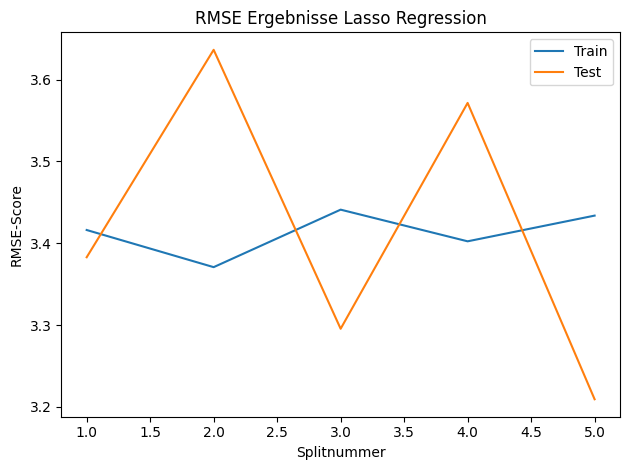

In [ ]:
# Lasso Regression mit Parameter alpha = 0.1 wird initialisiert (beim Rumprobieren sind mit 0.1 die besten Ergebnisse erzielt worden)
reg_lass = Lasso(alpha=0.1)

# Initialisiere Listen um RMSE-Werte speichern zu können
rmse_lass_list_train = []
rmse_lass_list_test = []

# TimeSeriesSplit für Crossvalidation
n = 5
tscv = TimeSeriesSplit(n_splits=n)

for train_index, test_index in tscv.split(ffill_all_data_df):
    # Trainiere das Modell
    reg_lass.fit(ffill_all_data_df[predictors].iloc[train_index], ffill_all_data_df[targets].iloc[train_index])

    # Mache Vorhersagen für Trainings- und Testdaten
    predictions_train = reg_lass.predict(ffill_all_data_df[predictors].iloc[train_index])
    predictions_test = reg_lass.predict(ffill_all_data_df[predictors].iloc[test_index])

    # Berechne RMSE für Trainings- und Testdaten und speichere in den Listen
    rmse_lass_train = mean_squared_error(ffill_all_data_df[targets].iloc[train_index], predictions_train)**0.5
    rmse_lass_test = mean_squared_error(ffill_all_data_df[targets].iloc[test_index], predictions_test)**0.5
    rmse_lass_list_train.append(rmse_lass_train)
    rmse_lass_list_test.append(rmse_lass_test)

# Plotte die RMSE-Werte
plt.plot(range(1, n+1), rmse_lass_list_train, label='Train')
plt.plot(range(1, n+1), rmse_lass_list_test, label='Test')
plt.title('RMSE Ergebnisse Lasso Regression')
plt.xlabel('Splitnummer')
plt.ylabel('RMSE-Score')
plt.legend()
plt.tight_layout()
plt.show()

# 4. **Multivariate Polynomial Regression**

In [ ]:
# Aufteilen in Features (X) und Zielvariable (y)

# Zeitreihen-Kreuzvalidierung
n = 5
tscv = TimeSeriesSplit(n_splits=n)  # Anzahl der Splits anpassen, wenn nötig

# Listen zum Speichern von Ergebnissen
rmse_train_list = []
rmse_test_list = []
r2_train_list = []
r2_test_list = []
count_rmse_tr = 0
count_rmse_te = 0
count_r2_tr = 0
count_r2_te = 0

#Höchsten Grad des Polynoms eingeben
highest_poly = 2

degrees = [i for i in range(1, highest_poly + 1)]

# Schleife über verschiedene Polynomgrade
for degree in degrees:
    print(f"Polynomgrad: {degree}")

    # Polynomial Features erstellen, include_bias sind die 1er-Spalten
    polynomial_features = PolynomialFeatures(degree=degree, include_bias=True)

    # Schleife über die Splits der Zeitreihen-Kreuzvalidierung
    for train_index, test_index in tscv.split(ffill_all_data_df):

        # Test- und Trainingssplit erstellen
        train, test = ffill_all_data_df.iloc[train_index], ffill_all_data_df.iloc[test_index]

        # unabhängige Variablen werden transformiert
        X_train_poly = polynomial_features.fit_transform(train[predictors])
        X_test_poly = polynomial_features.transform(test[predictors])

        # Targets festlegen
        y_train = train["LUFTTEMPERATUR_TARGET_TAG_1"]
        y_test = test["LUFTTEMPERATUR_TARGET_TAG_1"]

        # Modell erstellen und trainieren
        model = LinearRegression()
        model.fit(X_train_poly, y_train)

        # Vorhersagen für Trainings- und Testdaten
        y_train_pred = model.predict(X_train_poly)
        y_test_pred = model.predict(X_test_poly)

        # Bewertung des Modells
        rmse_train = (mean_squared_error(y_train, y_train_pred))**0.5
        rmse_test = (mean_squared_error(y_test, y_test_pred))**0.5

        r2_train = r2_score(y_train, y_train_pred)
        r2_test = r2_score(y_test, y_test_pred)
        print(f"RMSE (Train): {rmse_train:.4f}, RMSE (Test): {rmse_test:.4f}")
        print(f"R^2 (Train): {r2_train:.4f}, R^2 (Test): {r2_test:.4f}")
        #print(f'RMSE(Tain) - RMSE(Test) = {rmse_train - rmse_test}')
        print("--------")

        # Ergebnisse zur Liste hinzufügen unter Bedingung das der wert kleiner als 50 ist
        rmse_train_list.append(rmse_train)
        rmse_test_list.append(rmse_test)
        r2_train_list.append(r2_train)
        r2_test_list.append(r2_test)

    print('\n\n')

Polynomgrad: 1
RMSE (Train): 2.1034, RMSE (Test): 2.1311
R^2 (Train): 0.9313, R^2 (Test): 0.9194
--------
RMSE (Train): 2.0630, RMSE (Test): 2.0103
R^2 (Train): 0.9295, R^2 (Test): 0.9496
--------
RMSE (Train): 2.0324, RMSE (Test): 1.9288
R^2 (Train): 0.9388, R^2 (Test): 0.9337
--------
RMSE (Train): 2.0011, RMSE (Test): 2.0788
R^2 (Train): 0.9382, R^2 (Test): 0.9383
--------
RMSE (Train): 2.0141, RMSE (Test): 1.8870
R^2 (Train): 0.9384, R^2 (Test): 0.9358
--------



Polynomgrad: 2
RMSE (Train): 2.1242, RMSE (Test): 4.9463
R^2 (Train): 0.9299, R^2 (Test): 0.5658
--------
RMSE (Train): 1.5685, RMSE (Test): 2.6323
R^2 (Train): 0.9593, R^2 (Test): 0.9135
--------
RMSE (Train): 1.5810, RMSE (Test): 1.9082
R^2 (Train): 0.9630, R^2 (Test): 0.9351
--------
RMSE (Train): 1.5958, RMSE (Test): 617742.9188
R^2 (Train): 0.9607, R^2 (Test): -5445154085.9125
--------
RMSE (Train): 1.6541, RMSE (Test): 8.8463
R^2 (Train): 0.9585, R^2 (Test): -0.4105
--------





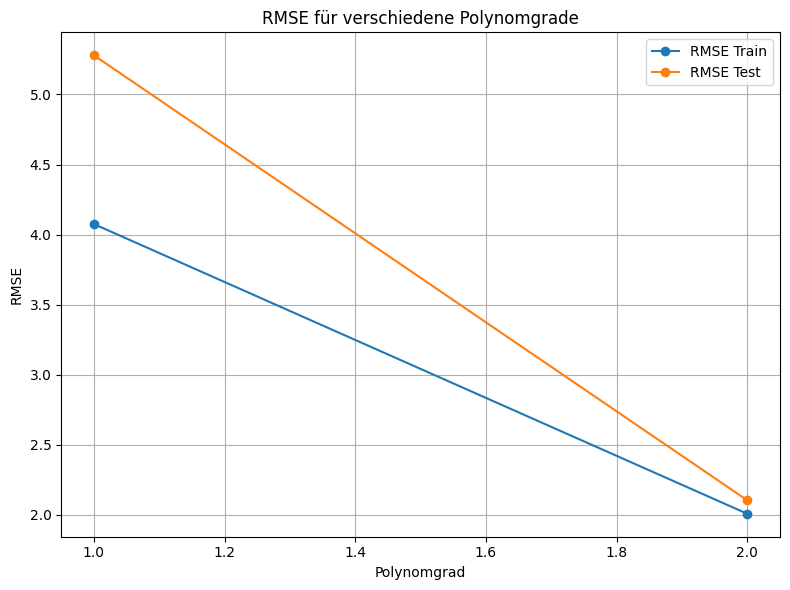

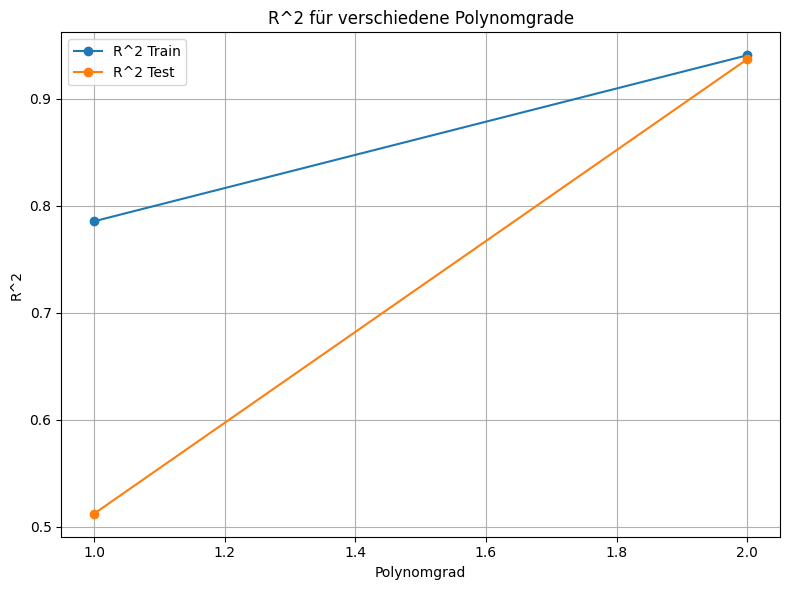

In [ ]:
filtered_degrees = []
filtered_rmse_train = []
filtered_rmse_test = []
filtered_r2_train = []
filtered_r2_test = []

# Filtere Werte über 50 und unter -10 (habe ich festgelegt, um eine klare Darstellung der Werte zu erreichen, weil ein R^2-Score von -237489239489235 schwierig in einem Plot darzustellen ist ;)
for i, degree in enumerate(degrees):
    if rmse_train_list[i] <= 50 and rmse_test_list[i] <= 50 and -10 <= r2_train_list[i] <= 1 and -10 <= r2_test_list[i] <= 1:
        filtered_degrees.append(degree)
        filtered_rmse_train.append(rmse_train_list[i])
        filtered_rmse_test.append(rmse_test_list[i])
        filtered_r2_train.append(r2_train_list[i])
        filtered_r2_test.append(r2_test_list[i])

# Plotte RMSE für Trainings- und Testdaten
plt.figure(figsize=(8, 6))
plt.plot(filtered_degrees, filtered_rmse_train, label='RMSE Train', marker='o')
plt.plot(filtered_degrees, filtered_rmse_test, label='RMSE Test', marker='o')
plt.title('RMSE für verschiedene Polynomgrade')
plt.xlabel('Polynomgrad')
plt.ylabel('RMSE')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plotte R^2 für Trainings- und Testdaten
plt.figure(figsize=(8, 6))
plt.plot(filtered_degrees, filtered_r2_train, label='R^2 Train', marker='o')
plt.plot(filtered_degrees, filtered_r2_test, label='R^2 Test', marker='o')
plt.title('R^2 für verschiedene Polynomgrade')
plt.xlabel('Polynomgrad')
plt.ylabel('R^2')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 5.**Decision Trees**

**Regression Tree**

Zunächst wird ein einfacher Decision Tree trainiert, um später Optimierungen besser einordnen zu können.

Zusätzlich werden die durschnittliche Ergebnisse für RMSE und R2 score für die jeweilige Baumtiefe ermittelt.

In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from math import sqrt
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit


tscv = TimeSeriesSplit(n_splits = 5)    #Teile die Zeitreihe auf

rmseTree_tr_list =[]
rmseTree_test_list = []
tree_score =[]

rmseTree_tr_list_temp =[]         #temporäre Listen um Durschnittswert für jeden Durchlauf von Time Series Split
rmseTree_test_list_temp = []
tree_score_temp =[]

#targets = "NIEDERSCHLAGSHOEHE_TARGET_TAG_3"

for depth in range(1, 16):    # Variiere die Tiefe des Baums
    for train_index, test_index in tscv.split(ffill_all_data_df):
        train, test = ffill_all_data_df.iloc[train_index], ffill_all_data_df.iloc[test_index]   #Teile die Daten des Splits in Train und Testdaten
        X_tree_train = train.loc[:, predictors]
        X_tree_test = test.loc[:, predictors]
        y_tree_train = train[targets]
        y_tree_test = test[targets]

        auto_tree = DecisionTreeRegressor(max_depth=depth)
        auto_tree.fit(X_tree_train, y_tree_train)

        y_hat_tree_train = auto_tree.predict(X_tree_train)
        y_hat_tree_test = auto_tree.predict(X_tree_test)

        rmseTree_tr = sqrt(mean_squared_error(y_hat_tree_train, y_tree_train))
        rmseTree_test = sqrt(mean_squared_error(y_hat_tree_test, y_tree_test))
        rmseTree_tr_list_temp.append(rmseTree_tr) #enhalten 5 Werte für jeden Split für Grad 1,..,16
        rmseTree_test_list_temp.append(rmseTree_test)
        tree_score_temp.append(auto_tree.score(X_tree_test, y_tree_test, sample_weight=None))

    rmseTree_tr_list.append(np.mean(rmseTree_tr_list_temp)) #Berechnung des RMSE Training Durchschnitts der Splits für Grad 1,...,16
    rmseTree_test_list.append(np.mean(rmseTree_test_list_temp))
    tree_score.append(np.mean(tree_score_temp))

    rmseTree_tr_list_temp = [] # Listen werden für die nächste Iteration geleert
    rmseTree_test_list_temp = []
    tree_score_temp = []



plt.figure(figsize=(10, 6))     #Plotte die durchschnittlichen Werte von 5 splits für rmse
plt.plot(range(1, 16), rmseTree_tr_list, label='Trainingsfehler')
plt.plot(range(1, 16), rmseTree_test_list, label='Testfehler')

plt.xlabel('Maximale Tiefe des Entscheidungsbaums')
plt.ylabel('RMSE')
plt.title('durchschnittlicher Trainings- und Testfehler für verschiedene Tiefen des Entscheidungsbaums')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))

plt.plot(range(1,16),tree_score, label = 'tree score test')  #Plotte die durchschnittlichen Werte von 5 splits für r2 score
plt.title('durchschnittlicher R^2 für verschiedene Tiefen des Entscheidungsbaums')
plt.ylabel('R^2')
plt.xlabel('Tiefen des Entscheidungsbaums')
plt.legend()
plt.show()


max(tree_score)

Die beste maximale Tiefe für die Temperatur liegt bei Tiefe 4.
Beim Niederschlag hingegen kommen sehr komische Ergebnisse heraus.
Laut Grafik wäre die beste Tiefe wohl bei 1. Und der R^2 Score nimmt negative Werte an sogar kleiner als -1.

Trainiere nun einen Baum mit der besten Tiefe für das Target um die Feature Importance anzeigen zu lassen.

In [ ]:
for train_index, test_index in tscv.split(ffill_all_data_df):
        train, test = ffill_all_data_df.iloc[train_index], ffill_all_data_df.iloc[test_index]
        X_tree_train = train.loc[:, predictors]
        X_tree_test = test.loc[:, predictors]
        y_tree_train = train[targets]
        y_tree_test = test[targets]

        auto_tree = DecisionTreeRegressor(max_depth=4)            #Trainiere den Baum mit Tiefe 4. Da dort RMSE für den Test am niedrigesten ist
        auto_tree.fit(X_tree_train, y_tree_train)

        y_hat_tree_train = auto_tree.predict(X_tree_train)
        y_hat_tree_test = auto_tree.predict(X_tree_test)

        feat_importance = auto_tree.tree_.compute_feature_importances(normalize=True)




In [ ]:
sorted_indices = np.argsort(feat_importance)          #Die Feature Importance des besten Baums. Man sieht das fast viele Features "rausgeschmissen werden"
plt.figure(figsize=(12, 8))                           #Auch interessant: Vier der sieben benutzten Features sind vom Arber/Schorndorf
plt.barh(range(len(feat_importance)), feat_importance[sorted_indices], align='center', color = 'blue')
plt.yticks(np.arange(len(feat_importance)), np.array(predictors)[sorted_indices])
plt.xlabel('Feature Importance')
plt.title('Decision Tree Feature Importance')
for index, value in enumerate(feat_importance[sorted_indices]):
    plt.text(value, index, f'{value:.4f}', ha='left', va='center')
plt.show()

Bei beiden Targets fällt auf das viele Features rausgeschmissen werden.
Erfreulich hier zu sehen ist, dass das Hinzufügen der 7 Tages Durchschnitte sich gelohnt hat. Bei der Temperatur nehmen sie zusammen ca. 7 Prozent an.

Niederschlag: Interessant hierbei ist das der Niederschlag von Arber mit dabei ist, während der Niederschlag von Straubing rausgeschmissen wird.

In [ ]:
from sklearn import tree
auto_tree.fit(X_tree_train, y_tree_train)       #Wie schaut dieser Baum nun aus?

plt.figure(figsize=(25, 20), dpi=80)
tree.plot_tree(auto_tree,
           feature_names = predictors,
           class_names= targets,
           filled = True);

# 5.1 **Pruning**
Unwichtige Zweige des Baumes werden entfernt. Dadurch wird die Prognose des Baumes besser. Der Baum hat nicht mehr so startkes Overfitting

Baum ist zunächst sehr groß und wird dann sukzessiv verkleinert.


In [ ]:
pruned_tree= DecisionTreeRegressor(random_state=0)

pruned_tree.fit(X_tree_train, y_tree_train)
y_hat_train_unpruned = pruned_tree.predict(X_tree_train)
y_hat_test_unpruned = pruned_tree.predict(X_tree_test)
rmseTree_tr_unpruned = sqrt(mean_squared_error(y_hat_train_unpruned, y_tree_train))   #um später die Ergebnisse mit den pruned tree vergleichen zu können
rmseTree_test_unpruned = sqrt(mean_squared_error(y_hat_test_unpruned, y_tree_test))

path = pruned_tree.cost_complexity_pruning_path(X_tree_train, y_tree_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities #cpp_alpha = penalty term, impuritie gibt Baumqualität an


In [ ]:
# Umso größer der Baum (Anzahl der Blätter) desto stärker durch alpha bestraft
fig, ax = plt.subplots()
ax.plot(ccp_alphas[:-1], impurities[:-1], marker="o", drawstyle="steps-post")
ax.set_xlabel("effektives alpha")
ax.set_ylabel("Unreinheit der leaves")
ax.set_title("Gesamte Unreinheit vs effektives alpha (Training)") #Gesamte Unreinheit = Summe Unreinheit der einzelnen Blätter

In [ ]:
len(ccp_alphas)

In [ ]:
#ca. 32 min Ladezeit
pruned_tree_list = []

for ccp_alpha in ccp_alphas:
    pruned_tree = DecisionTreeRegressor(random_state=0, ccp_alpha=ccp_alpha)
    pruned_tree.fit(X_tree_train, y_tree_train)
    pruned_tree_list.append(pruned_tree)
print(
    "Number of nodes in the last tree is: {} with ccp_alpha: {}".format(
        pruned_tree_list[-1].tree_.node_count, ccp_alphas[-1]
    )
)


In [ ]:
pruned_tree_list = pruned_tree_list[:-1]      #Entferne den trivialen Baum (Tiefe 1)
ccp_alphas = ccp_alphas[:-1]


In [ ]:
train_scores = [pruned_tree.score(X_tree_train, y_tree_train) for pruned_tree in pruned_tree_list]
test_scores = [pruned_tree.score(X_tree_test, y_tree_test) for pruned_tree in pruned_tree_list]


fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("r2 score")
ax.set_title("r2 score vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker="o", label="train", drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker="o", label="test", drawstyle="steps-post")
ax.legend()
plt.show()

Bei kleinen $\alpha$ ist liegt der R^2 Score für die Trainingsmenge fast bei 1, bei der Testmenge ist er aber klein. Dort herrscht Overfitting.

Suche nun dasjenige alpha das den besten test score liefert

In [ ]:
max_test_score=np.max(test_scores)
index_max_test=test_scores.index(max_test_score)
print('maximaler r2 score (test):',max_test_score,'; Position Max:',index_max_test)

In [ ]:
ccp_alphas[index_max_test]

Vergleiche den pruned tree mit den Baum mit der besten Tiefe von oben.


In [ ]:
pruned_tree_opt=DecisionTreeRegressor(ccp_alpha=ccp_alphas[index_max_test])
pruned_tree_opt.fit(X_tree_train,y_tree_train)

normal_tree = DecisionTreeRegressor(max_depth=4)      #Vergleiche den pruned tree mit den oben besten
normal_tree.fit(X_tree_train,y_tree_train)


y_hat_train_opt = pruned_tree_opt.predict(X_tree_train)
y_hat_test_opt = pruned_tree_opt.predict(X_tree_test)

y_hat_train_normal = normal_tree.predict(X_tree_train)
y_hat_test_normal = normal_tree.predict(X_tree_test)

rmseTree_tr_opt = sqrt(mean_squared_error(y_hat_train_opt,y_tree_train))
rmseTree_test_opt = sqrt(mean_squared_error(y_hat_test_opt,y_tree_test))

rmseTree_tr_normal = sqrt(mean_squared_error(y_hat_train_normal,y_tree_train))
rmseTree_test_normal = sqrt(mean_squared_error(y_hat_test_normal,y_tree_test))

print('Trainingsfehler (pruned):',rmseTree_tr_opt,'; Trainingsfehler (tree with best depth) ',rmseTree_tr_normal)
print('Testfehler (pruned):',rmseTree_test_opt,'; Testfehler (tree with best depth)',rmseTree_test_normal)
print('score (pruned):', pruned_tree_opt.score(X_tree_test, y_tree_test), ";score (tree with best depth)", normal_tree.score(X_tree_test, y_tree_test))

Dar Pruning hat etwas gebracht!
Sowohl Training- als auch Testfehler schneiden besser ab.
Der r2 score fällt um 0.7 besser aus als bei den Baum mit der besten Tiefe (4)

In [ ]:
plt.figure(figsize=(25, 20), dpi=80)      #Wie schaut dieser Baum aus?
tree.plot_tree(pruned_tree_opt,
           feature_names = predictors,
           class_names= targets,
           filled = True);

In [ ]:
feat_importance = pruned_tree_opt.feature_importances_

sorted_indices = np.argsort(feat_importance)          #Die Feature Importance des besten Baums. Man sieht das fast viele Features "rausgeschmissen werden"
plt.figure(figsize=(12, 8))                           #Auch interessant: Vier der sieben benutzten Features sind vom Arber/Schorndorf
plt.barh(range(len(feat_importance)), feat_importance[sorted_indices], align='center', color = 'red')
plt.yticks(np.arange(len(feat_importance)), np.array(predictors)[sorted_indices])
plt.xlabel('Feature Importance')
plt.title('Decision Tree Feature Importance')
for index, value in enumerate(feat_importance[sorted_indices]):
    plt.text(value, index, f'{value:.4f}', ha='left', va='center')
plt.show()

Nun wollen wir mal grafisch veranschaulichen wie die vorhergesagten Werte verlaufen.

In [ ]:
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(y_tree_train.values.ravel(), label='Tatsächliche Werte (Trainingsdaten)', color='blue')
plt.plot(y_hat_train_opt, label='Vorhersagen (Trainingsdaten)', color='red', linestyle='dashed')
plt.title('Vorhersagen vs. Tatsächliche Werte - Trainingsdaten')
plt.xlabel('Index')
plt.ylabel('Temperatur')
plt.legend()


plt.subplot(2, 1, 2)
plt.plot(y_tree_test.values.ravel(), label='Tatsächliche Werte (Testdaten)', color='blue')
plt.plot(y_hat_test_opt, label='Vorhersagen (Testdaten)', color='red', linestyle='dashed')
plt.title('Vorhersagen vs. Tatsächliche Werte - Testdaten')
plt.xlabel('Index')
plt.ylabel('Temperatur')
plt.legend()


plt.tight_layout()
plt.show()


# 5.2 **Bagging**

Beginnen wir nun mit ensemble learning Verfahren.

Trainiere mehrere Modelle und aggregiere die Vorhersagen.

In [ ]:
from sklearn.ensemble import BaggingRegressor

AutoBagReg = BaggingRegressor(estimator=DecisionTreeRegressor(),
                         n_estimators=10, random_state=0, bootstrap=True).fit(X_tree_train, y_tree_train.values.ravel())

y_hat_train_Bag = AutoBagReg.predict(X_tree_train)
y_hat_test_Bag = AutoBagReg.predict(X_tree_test)

In [ ]:
rmseTree_Bag_tr = sqrt(mean_squared_error(y_hat_train_Bag,y_tree_train))
rmseTree_Bag_test = sqrt(mean_squared_error(y_hat_test_Bag,y_tree_test))

print('Trainingsfehler:',rmseTree_Bag_tr)
print('Testfehler:',rmseTree_Bag_test)

In [ ]:
AutoBagReg_test_r2=AutoBagReg.score(X_tree_test,y_tree_test)

AutoBagReg_test_r2


In [ ]:
import matplotlib.pyplot as plt
#1h 54 min

avg_rmseTest_list = [] #Listen mit Durchschnittswerten
avg_rmseTrain_list = []
avg_r2_score_list = []

#targets = "NIEDERSCHLAGSHOEHE_TARGET_TAG_3"

estimator_range = range(10, 100)

for estimators in estimator_range: #finde die beste Anzahl an Bäumen für das Modell
    rmseTree_Bag_test_list = []
    rmseTree_Bag_train_list = []
    AutoBagReg_test_r2_list = []

    for train_index, test_index in tscv.split(ffill_all_data_df):
        train, test = ffill_all_data_df.iloc[train_index], ffill_all_data_df.iloc[test_index]

        X_tree_train = train.loc[:, predictors]
        X_tree_test = test.loc[:, predictors]
        y_tree_train = train[targets]
        y_tree_test = test[targets]

        AutoBagReg = BaggingRegressor(
            estimator=DecisionTreeRegressor(),
            n_estimators=estimators,
            random_state=0,
            bootstrap=True
        ).fit(X_tree_train, y_tree_train.values.ravel())

        y_hat_train_Bag = AutoBagReg.predict(X_tree_train)
        y_hat_test_Bag = AutoBagReg.predict(X_tree_test)


        rmseTree_Bag_train = sqrt(mean_squared_error(y_hat_train_Bag, y_tree_train.values.ravel()))
        rmseTree_Bag_test = sqrt(mean_squared_error(y_hat_test_Bag, y_tree_test.values.ravel()))

        rmseTree_Bag_train_list.append(rmseTree_Bag_train)
        rmseTree_Bag_test_list.append(rmseTree_Bag_test)


        AutoBagReg_test_r2 = r2_score(y_tree_test, y_hat_test_Bag)
        AutoBagReg_test_r2_list.append(AutoBagReg_test_r2)


    avg_rmseTrain_list.append(np.mean(rmseTree_Bag_train_list)) # Durchschnittliche Werte für jeden Split
    avg_rmseTest_list.append(np.mean(rmseTree_Bag_test_list))
    avg_r2_score_list.append(np.mean(AutoBagReg_test_r2_list))


plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(estimator_range, avg_rmseTrain_list, label="Durchschnittlicher Trainingsfehler (RMSE)")
plt.plot(estimator_range, avg_rmseTest_list, label="Durchschnittlicher Testfehler (RMSE)")
plt.xlabel("Anzahl Bäume")
plt.ylabel("RMSE")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(estimator_range, avg_r2_score_list, label="Durchschnittlicher R2 Score")
plt.xlabel("Anzahl Bäume")
plt.ylabel("R2 Score")
plt.legend()

plt.tight_layout()
plt.show()


Bei Tiefe 40 hat das Modell fast den besten Metriken. Danach sinken sie nur noch leicht.
Nun berechnen wir noch den maximalen score.

In [ ]:
estimator_range = range(10, 100)

x= round(ffill_all_data_df.shape[0]*0.8)        #wir benutzen hier einen Split mit Testsize 0.2, weil der Rechenaufwand hier sonst zu groß wäre. Das Ergebnis wäre mit TimeSeriesSplit nur minimal anders.

train, test = ffill_all_data_df.iloc[:x], ffill_all_data_df.iloc[x:]


X_tree_train = train.loc[:, predictors]
X_tree_test = test.loc[:, predictors]
y_tree_train = train[targets]
y_tree_test = test[targets]

for estimators in estimator_range: #finde die beste Anzahl an Bäumen für das Modell
    rmseTree_Bag_test_list = []
    rmseTree_Bag_train_list = []
    AutoBagReg_test_r2_list = []

    AutoBagReg = BaggingRegressor(
        estimator=DecisionTreeRegressor(),
        n_estimators=estimators,
        random_state=0,
        bootstrap=True
    ).fit(X_tree_train, y_tree_train.values.ravel())

    y_hat_train_Bag = AutoBagReg.predict(X_tree_train)
    y_hat_test_Bag = AutoBagReg.predict(X_tree_test)


    rmseTree_Bag_train = sqrt(mean_squared_error(y_hat_train_Bag, y_tree_train.values.ravel()))
    rmseTree_Bag_test = sqrt(mean_squared_error(y_hat_test_Bag, y_tree_test.values.ravel()))

    rmseTree_Bag_train_list.append(rmseTree_Bag_train)
    rmseTree_Bag_test_list.append(rmseTree_Bag_test)


    AutoBagReg_test_r2 = r2_score(y_tree_test, y_hat_test_Bag)
    AutoBagReg_test_r2_list.append(AutoBagReg_test_r2)

In [ ]:
max_index = AutoBagReg_test_r2_list.index(max(AutoBagReg_test_r2_list))     # finde den Index des besten R2 scores und gebe rmse für train und test dort aus
print("best test score",AutoBagReg_test_r2_list[max_index],"rmse_Train", rmseTree_Bag_train_list[max_index],"rmse_Test", rmseTree_Bag_test_list[max_index])

**Out-Of-Bag**


In [ ]:
BagReg_OOB = BaggingRegressor(estimator=DecisionTreeRegressor(),
                         n_estimators=50, random_state=0, bootstrap=True,
                                  oob_score=True)

BagReg_OOB.fit(X_tree_train, y_tree_train.values.ravel())

In [ ]:
BagReg_OOB_r2=BagReg_OOB.oob_score_ #r2-score (OOB)

corr_OOB=sqrt(BagReg_OOB_r2)  #Pearson-Korrelation (OOB)
BagReg_OOB_r2

In [ ]:
y_hat_OOB=BagReg_OOB.predict(X_tree_test)


corr_test_OOB = np.corrcoef(y_tree_test.values.ravel(), y_hat_OOB)[0, 1]


print('Korrelation auf den OOB samples:',corr_OOB)
print('Korrelation auf der Testmenge:',corr_test_OOB)


Die Korrelationen sind sehr nah beieinander. Das bedeutet, dass das Modell in der Lage ist, die tatsächlichen Werte sowohl in den Daten, auf denen es trainiert wurde, als auch in einer neuen Datenmenge mit einer sehr ähnlichen Genauigkeit vorherzusagen.

# 5.3 **Random Forest**

Bei Bagging ist die Struktur der Modelle untereinander zu änlich.
Benutze Random Forest um zufällige Anzahl an Features pro Baum zu haben

In [ ]:
from sklearn.ensemble import RandomForestRegressor

In [ ]:
RF_Straubing=RandomForestRegressor(n_estimators=100, max_leaf_nodes=10)     #Teste einfaches Modell
RF_Straubing=RF_Straubing.fit(X_tree_train,y_tree_train.values.ravel())
RF_Straubing.score(X_tree_test, y_tree_test)

In [ ]:
import numpy as np


n_estimators_list = []
train_score_list = []
test_score_list = []
rf_test_score_list = []
data_test = []  # Liste mit den relevanten Daten. Diese wird am Ende nach dem Testscore sortiert
rmseTree_RF_train = []
rmseTree_RF_test =[]



x= round(ffill_all_data_df.shape[0]*0.8)        #wir benutzen hier einen Split mit Testsize 0.2, weil der Rechenaufwand hier sonst zu groß wäre. Das Ergebnis wäre mit TimeSeriesSplit nur minimal anders.

train, test = ffill_all_data_df.iloc[:x], ffill_all_data_df.iloc[x:]
X_tree_train = train.loc[:, predictors]
X_tree_test = test.loc[:, predictors]
y_tree_train = train[targets]
y_tree_test = test[targets]


for estimators in range(1, 70):  # Beste Kombination der Hyperparameter bestimmen
    for max_leaf in range(2, 30):
        RF_Straubing = RandomForestRegressor(n_estimators=estimators, max_leaf_nodes=max_leaf)
        RF_Straubing = RF_Straubing.fit(X_tree_train, y_tree_train.values.ravel())

        train_score = RF_Straubing.score(X_tree_train, y_tree_train)
        test_score = RF_Straubing.score(X_tree_test, y_tree_test)

        train_score_list.append(train_score)
        test_score_list.append(test_score)

        y_hat_train_RF = RF_Straubing.predict(X_tree_train)
        y_hat_test_RF = RF_Straubing.predict(X_tree_test)
        rmseTree_RF_train.append(sqrt(mean_squared_error(y_hat_train_RF, y_tree_train.values.ravel())))
        rmseTree_RF_test.append(sqrt(mean_squared_error(y_hat_test_RF, y_tree_test.values.ravel())))
        rf_test_score_list.append(RF_Straubing.score(X_tree_test, y_tree_test))




In [ ]:
max_index = rf_test_score_list.index(max(rf_test_score_list))     # finde den Index des besten R2 scores und gebe rmse für train und test dort aus
print("best test score",rf_test_score_list[max_index],"rmse_Train", rmseTree_RF_train[max_index],"rmse_Test", rmseTree_RF_test[max_index])

**Out of Bag**

In [ ]:
RF_OOB = RandomForestRegressor(n_estimators=100, max_leaf_nodes=10, oob_score=True)
RF_OOB.fit(X_tree_train, y_tree_train.values.ravel())      #Man nimmt hier zwar nur den letzten Split, aber es geht lediglich um die Interpretation
RF_OOB_r2= RF_OOB.oob_score_

corr_OOB=sqrt(RF_OOB_r2)

y_hat_OOB= RF_OOB.predict(X_tree_test)
corr_test_OOB = np.corrcoef(y_tree_test.values.ravel(), y_hat_OOB)[0, 1]

print('Korrelation auf den OOB samples:',corr_OOB)
print('Korrelation auf der Testmenge:',corr_test_OOB)

Eigentlich identisch wie bei Bagging. Das Modell generalisiert gut.

Test: Verlauf des RMSE und R^2 score im Verlauf der Tage. Am Beispiel Random Forest

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.model_selection import TimeSeriesSplit

tscv = TimeSeriesSplit(n_splits=5)

target_temperature_list = ["LUFTTEMPERATUR_TARGET_TAG_1", "LUFTTEMPERATUR_TARGET_TAG_2", "LUFTTEMPERATUR_TARGET_TAG_3"]
target_rain_list =["NIEDERSCHLAGSHOEHE_TARGET_TAG_1","NIEDERSCHLAGSHOEHE_TARGET_TAG_2", "NIEDERSCHLAGSHOEHE_TARGET_TAG_3"]

avg_rmseTree_RF_train_lists = []
avg_rmseTree_RF_test_lists = []
avg_train_score_lists = []
avg_test_score_lists = []

for target in target_temperature_list:        #Wenn man den Verlauf über die Tage für den Niederschlag anschauen will so muss man hier die target_rain_list einfügen
    avg_rmseTree_RF_train_list = []    #Erstelle Listen um den Durschnitt Splits zu erhalten
    avg_rmseTree_RF_test_list = []
    avg_train_score_list = []
    avg_test_score_list = []

    for train_index, test_index in tscv.split(ffill_all_data_df):
        train, test = ffill_all_data_df.iloc[train_index], ffill_all_data_df.iloc[test_index]
        X_tree_train = train.loc[:, predictors]
        X_tree_test = test.loc[:, predictors]
        y_tree_train = train[target]
        y_tree_test = test[target]

        RF_Straubing = RandomForestRegressor(n_estimators=60, max_leaf_nodes=10)
        RF_Straubing = RF_Straubing.fit(X_tree_train, y_tree_train.values.ravel())

        train_score = RF_Straubing.score(X_tree_train, y_tree_train)
        test_score = RF_Straubing.score(X_tree_test, y_tree_test)

        y_hat_train_RF = RF_Straubing.predict(X_tree_train)
        y_hat_test_RF = RF_Straubing.predict(X_tree_test)

        rmseTree_RF_train = sqrt(mean_squared_error(y_hat_train_RF, y_tree_train.values.ravel()))
        rmseTree_RF_test = sqrt(mean_squared_error(y_hat_test_RF, y_tree_test.values.ravel()))

        avg_train_score_list.append(train_score)
        avg_test_score_list.append(test_score)
        avg_rmseTree_RF_train_list.append(rmseTree_RF_train)
        avg_rmseTree_RF_test_list.append(rmseTree_RF_test)


    avg_train_score = np.mean(avg_train_score_list)
    avg_test_score = np.mean(avg_test_score_list)
    avg_rmseTree_RF_train = np.mean(avg_rmseTree_RF_train_list)
    avg_rmseTree_RF_test = np.mean(avg_rmseTree_RF_test_list)

    avg_train_score_lists.append(avg_train_score)
    avg_test_score_lists.append(avg_test_score)
    avg_rmseTree_RF_train_lists.append(avg_rmseTree_RF_train)
    avg_rmseTree_RF_test_lists.append(avg_rmseTree_RF_test)

# Erstellen Sie dynamisch die X-Achse basierend auf der Anzahl der Target-Werte
x_axis_targets = ["Tag{}".format(i + 1) for i in range(len(target_temperature_list))]

# Plot für durchschnittlichen RMSE Train und Test
plt.figure(figsize=(8, 6))
plt.plot(x_axis_targets, avg_rmseTree_RF_train_lists, label='Average RMSE_train', marker='o')
plt.plot(x_axis_targets, avg_rmseTree_RF_test_lists, label='Average RMSE_test', marker='o')
plt.ylabel('Average Root Mean Squared Error (RMSE)')
plt.title('Average RMSE_train and RMSE_test over 3 days')
plt.legend()
plt.show()

# Plot für durchschnittliche Train- und Test-Scores
plt.figure(figsize=(8, 6))
plt.plot(x_axis_targets, avg_train_score_lists, label='Average Train Score', marker='o')
plt.plot(x_axis_targets, avg_test_score_lists, label='Average Test Score', marker='o')
plt.ylabel('Average Score')
plt.title('Average Train and Test Scores over 3 days')
plt.legend()
plt.show()


Schön anhand der Grafik zu sehen, wie die Metriken mit zunehmenden Prognosehorizont schlechter werden.
Es fällt auch auf dass die Metriken von Tag 1 auf Tag 2 im Verhältnis stärker abnehmen als von Tag 2 auf Tag 3.

# 5.4 **Boosting**

Fehler vom Vorgänger-Modell korriegieren

In [ ]:
from sklearn.tree import DecisionTreeRegressor

Straubing_tree = DecisionTreeRegressor(max_depth=4,criterion='squared_error')   #Nehme wieder die maximale Tiefe 4 wie am Anfang errechnet


In [ ]:
from sklearn.ensemble import AdaBoostRegressor

ada_Straubing = ada_Heart=AdaBoostRegressor(DecisionTreeRegressor(max_depth=4),n_estimators=100,learning_rate=0.5)
ada_Straubing.fit(X_tree_train, y_tree_train.ravel())


In [ ]:
ada_Straubing.score(X_tree_test, y_tree_test)


In [ ]:
lr_list=[]
train_score_list_ada=[]
test_score_list_ada=[]
best_config =[]
rmse_test_list_ada = []
rmse_train_list_ada = []
targets = "NIEDERSCHLAGSHOEHE_TARGET_TAG_3"

x= round(ffill_all_data_df.shape[0]*0.8)        #wir benutzen hier einen Split mit Testsize 0.2, weil der Rechenaufwand hier sonst zu groß wäre. Das Ergebnis wäre mit TimeSeriesSplit nur minimal anders.

train, test = ffill_all_data_df.iloc[:x], ffill_all_data_df.iloc[x:]

X_tree_train = train.loc[:, predictors]
X_tree_test = test.loc[:, predictors]
y_tree_train = train[targets]
y_tree_test = test[targets]



for max_depth in range (1,40):                  #Man kann hier drei Hyperparameter optimieren, aus Gründen der Rechendauer wurde jedoch die Anzahl der Entscheidungbäume auf 60 festgelegt. Da sich vorher rausstellte dass das ein guter Wert dafür ist.
    for learnrate in range(1,20):

      ada_Heart=AdaBoostRegressor(DecisionTreeRegressor(max_depth=max_depth),n_estimators=60,learning_rate=learnrate)
      ada_Heart.fit(X_tree_train,y_tree_train.ravel())
      train_score=ada_Heart.score(X_tree_train, y_tree_train)
      test_score=ada_Heart.score(X_tree_test, y_tree_test)

      y_hat_train_ada = ada_Straubing.predict(X_tree_train)
      y_hat_test_ada = ada_Straubing.predict(X_tree_test)

      rmseTree_ada_train = sqrt(mean_squared_error(y_hat_train_ada, y_tree_train.values.ravel()))
      rmseTree_ada_test = sqrt(mean_squared_error(y_hat_test_ada, y_tree_test.values.ravel()))
      rmse_train_list_ada.append(rmseTree_ada_train)
      rmse_test_list_ada.append(rmseTree_ada_test)

      train_score_list_ada.append(train_score)
      test_score_list_ada.append(test_score)
      lr_list.append(learnrate)




In [ ]:
max_index = test_score_list_ada.index(max(test_score_list_ada))     # finde den Index des besten R2 scores und gebe rmse für train und test dort aus
print("best test score",test_score_list_ada[max_index],"rmse_Train", rmse_train_list_ada[max_index],"rmse_Test", rmse_test_list_ada[max_index])

Die Ergebnisse sind leicht schlechter als beim Random Forest. Jedoch wurden auch nicht die Anzahl der Bäume (estimators) hier nicht optimiert, was noch zu kleinen Verbesserungen führen würde.

# 6. **Neuronale Netze**

In [ ]:
import tensorflow as tf
from tensorflow import keras

from keras.models import Sequential
from keras.layers import InputLayer, Dense

from IPython.display import clear_output
class PlotLosses(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []

        self.fig = plt.figure()

        self.logs = []

    def on_epoch_end(self, epoch, logs={}):

        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.i += 1

        clear_output(wait=True)
        plt.plot(self.x, self.losses, label="loss")
        plt.plot(self.x, self.val_losses, label="val_loss")
        plt.legend()
        plt.show()

plot_losses = PlotLosses()

EarlyStopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

#target = ['LUFTTEMPERATUR_TARGET_TAG_3']     # hier muss per Hand variert werden, die Aufgabe wurde hauptsächlich mit der Lufttemperatur durchgeführt
target = ['NIEDERSCHLAGSHOEHE_TARGET_TAG_3']  # (Rechenleistung und Zeit kann gespart werden), da hier bewertbare Vorhersagen getroffen werden

**Daten skalieren und Split erstellen**<br>Zum Testen der einzelnen Modell wir auf den TimeSeriesSplit verzichtet. Um den Rechenaufwand klein zu halten wird also ein einheitlicher 80/20 Split verwendet, welcher die Zeitreihe beibehält.

In [ ]:
scaler = MinMaxScaler()

x = round(ffill_all_data_df.shape[0]*0.8)

X_train = np.array(ffill_all_data_df[predictors].iloc[:x])
X_test = np.array(ffill_all_data_df[predictors].iloc[x:])
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Y_train = np.array(ffill_all_data_df[target].iloc[:x])
Y_test = np.array(ffill_all_data_df[target].iloc[x:])
Y_train_scaled = scaler.fit_transform(Y_train)
Y_test_scaled = scaler.transform(Y_test)

**Erstellen eines Baseline Modells zum Testen**<br>Ein simples Layout mit einer Hidden-Layer und 16 Neuronen.

In [ ]:
model_test = Sequential()

optimizer = keras.optimizers.Adam(learning_rate=0.0001)

model_test.add(InputLayer(input_shape=(None,len(predictors))))
model_test.add(Dense(16, activation='tanh', use_bias=True))
model_test.add(Dense(1,use_bias=True))

model_test.compile(loss='mean_squared_error', optimizer=optimizer)

Fitten des Modells auf die skalierten Trainingsdaten.

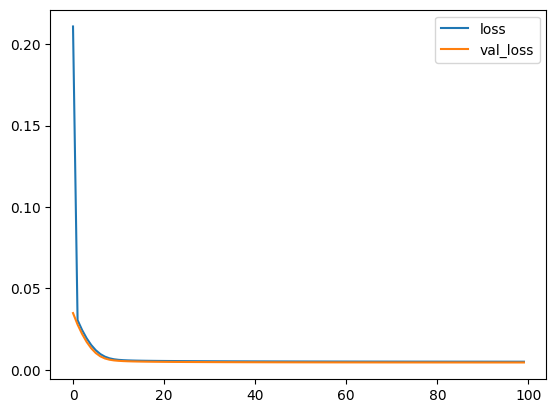

45/45 [==============================] - 0s 2ms/step


In [ ]:
model_test.fit(X_train_scaled,Y_train_scaled,
               shuffle=False,
               epochs=100,
               batch_size=10,
               verbose=1,
               validation_data=(X_test_scaled, Y_test_scaled),
               callbacks=[plot_losses]) #EarlyStopping ist nicht nötig, da es nicht zum Overfitting kommt

y_hat_tr_scaled=model_test.predict(X_train_scaled)
y_hat_test_scaled=model_test.predict(X_test_scaled)

In [ ]:
y_hat_test  = scaler.inverse_transform(y_hat_test_scaled)   #skalierte Predictions zurück auf die ursprüngliche Skala bringen
y_hat_tr = scaler.inverse_transform(y_hat_tr_scaled)

rmse_NN_tr = sqrt(mean_squared_error(y_hat_tr,Y_train))
rmse_NN_test = sqrt(mean_squared_error(y_hat_test,Y_test))

r2_score_train = r2_score(Y_train, y_hat_tr)
r2_score_test = r2_score(Y_test,y_hat_test)

print('R2-score Train:', r2_score_train)
print('R2-score Test:', r2_score_test)

print('RMSE Train:',rmse_NN_tr)
print('RMSE Test:',rmse_NN_test)

R2-score Train: -0.015292400144206297
R2-score Test: -0.009588400427152699
RMSE Train: 4.297693087304669
RMSE Test: 4.091253311709902


Das Baseline-Modell liefert bereits eine gute Performance und es tritt ebenfalls kein Overfitting auf, weshalb sich die Regularisierung mittels Weight Decay gespart werden kann. Jetzt kann noch optimiert werden, hierzu wird ein Ensemble Modell verwendet bei welchem folgende Parameter angepasst werden:<br>
*   Batch Size
*   Anzahl der Epochen
*   Anzahl der Layers
*   Anzahl der Neuronen
*   Aktivierungsdunktion
*   Optimizer und Lernrate

<br> Verwendet wird wieder der selbe 80/20 Split, alternativ kann natürlich auch der TimeSeriesSplit herangezogen werden.





In [ ]:
def fit_model(activation, learning_rate, epochs, batch_size):

    EarlyStopping = keras.callbacks.EarlyStopping(monitor='loss', patience=10,restore_best_weights=True)

    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

    model = Sequential()
    model.add(InputLayer(input_shape=(None,len(predictors))))
    model.add(Dense(64,activation=activation,use_bias=True))    #andere Aktivierungsfunktionen testen!!! softmax gute performance
    model.add(Dense(32,activation=activation, use_bias=True))
    model.add(Dense(16, activation=activation, use_bias=True))
    model.add(Dense(1,use_bias=True))

    model.compile(loss='mean_squared_error', optimizer=optimizer)

    model.fit(X_train_scaled,Y_train_scaled,  #callbacks hinzufügen, um Overfitting zu verhindern
               shuffle=False,
               epochs=epochs,
               batch_size=batch_size,
               validation_data=(X_test_scaled, Y_test_scaled),
               verbose=0,
               callbacks = [plot_losses])  #EarlyStopping ist nicht nötig, da es nicht zum Overfitting kommt

    return model

In [ ]:
def ensemble(n_models, activation, learning_rate, epochs, batch_size):
    all_rmse_train = []
    all_rmse_test = []
    all_r2_train = []
    all_r2_test = []
    models = []

    targets = ['LUFTTEMPERATUR_TARGET_TAG_3']

    for n in range(n_models):

        model = fit_model(activation, learning_rate, epochs, batch_size)
        models.append(model)

    for model in models:
        y_hat_train_scaled = model.predict(X_train_scaled)
        y_hat_test_scaled = model.predict(X_test_scaled)
        #scale back
        y_hat_train = scaler.inverse_transform(y_hat_train_scaled)
        y_hat_test = scaler.inverse_transform(y_hat_test_scaled)

        rmse_train = sqrt(mean_squared_error(y_hat_train, Y_train))
        rmse_test = sqrt(mean_squared_error(y_hat_test, Y_test))
        r2_train = r2_score(y_hat_train, Y_train)
        r2_test = r2_score(y_hat_test, Y_test)

        all_rmse_train.append(rmse_train)
        all_rmse_test.append(rmse_test)
        all_r2_train.append(r2_train)
        all_r2_test.append(r2_test)

        print(rmse_train, rmse_test, r2_train, r2_test)

    avg_rmse_test = sum(all_rmse_test)/len(all_rmse_test)
    avg_rmse_train = sum(all_rmse_train)/len(all_rmse_train)
    avg_r2_test = sum(all_r2_test)/len(all_r2_test)
    avg_r2_train = sum(all_r2_train)/len(all_r2_train)

    return avg_rmse_train, avg_rmse_test, avg_r2_train, avg_r2_test

In [ ]:
n_models = 5
activation = 'tanh'
learning_rate = 0.0001
epochs = 100
batch_size = 10
avg_rmse_train, avg_rmse_test, avg_r2_train, avg_r2_test = ensemble(n_models, activation, learning_rate, epochs, batch_size)

Die oben zu sehenden Einstellungen wurden nach etlichen Tests als optimal festgestellt. Allerdings war zu erkennen, dass sich die Ergebnisse bei säntlichen Variationen nur minimal voneinander unterschieden haben.<br> **Das Resultat** der NN war also äußerst ernüchternt, denn die Performance konnte gegenüber der multivariaten Regression nicht signifikant bzw. gar nicht gesteigert werden.

# **7. Abschließende Analyse**

Interssant war es zu sehen, dass die Vorhersage der multivariaten Regression nur leicht schlechter waren als die des neuronalen Netzes. Vermutlich ist der Grund dafür dass es einen linearen Zusammenhang zwischen Temperatur und den verwendeten Features gibt. Es werden hauptsächlich andere Temperatur-Features für die Prognose benutzt. Die multivariate lineare Regression erreicht mit den zur Verfügung stehenden Daten bereits das bestmögliche Ergebnis und sowohl die Decision Tress, als auch die Neuronalen Netze konnte keine weitere signifikante Verbesserung erzielen.

Die Vorhersagen für den Niederschlag fielen durchweg schlecht aus. Das war bereits beim Bertrachten der Korrelationsmatrix zu befürchten. Das höchstkorrelierenste Feature hat eine Korrelation von 0.11. Beim Niederschlag haben also herkömmliche Wettervorhersagesysteme deutliche bessere Methoden um diese Metrik zu bestimmen. Hinzu kommt, dass für eine verlässlichere Vorhersage weitere Daten, wie großflächige Daten über Hoch- und Tiefdruckgebiete etc., fehlen.

Bei der Temperatur hingegen sind wir zufrieden mit den Ergebnisssen. Hierbei kommen wir bereits mit einfachen Machine Learning Modellen auf gute Prognosen.


Wichtig zu erwähnen ist allerdings, dass beim genaueren Hinsehen der Prognosen das Phänomen des Time lags auffällt. Hierzu werden beispielhaft die Ergebnisse des Neuronalen Netzes dargestellt.

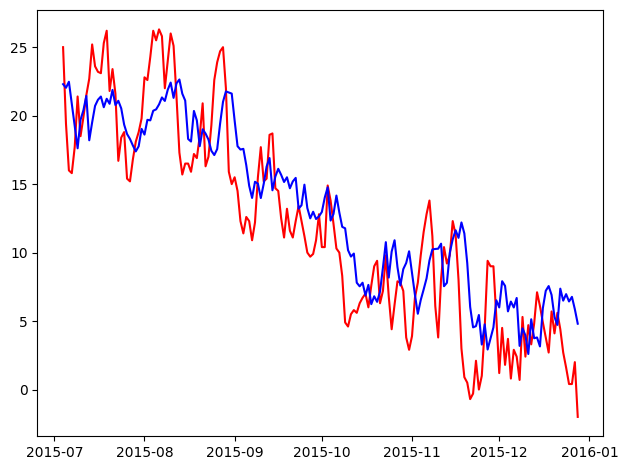

In [ ]:
plt.plot(ffill_all_data_df.iloc[7000:7400].index, ffill_all_data_df['LUFTTEMPERATUR_TARGET_TAG_3'].iloc[7000:7400], color='red')
plt.plot(ffill_all_data_df.iloc[7000:7400].index, np.append(y_hat_tr, y_hat_test)[7000:7400], color='blue')
plt.tight_layout()
plt.show()

Es wird ersichtlich, dass die Vorhersagen rechnerisch zwar als sehr gut erscheinen, bei genauerem Hinsehen aber deutlich wird, dass das Modell sehr naiv ist. Das Modell zieht den tatsächlichen Wetterdaten also lediglich immer hinterher und sagt die Temperatur, zumindest für den dritten Tag, nie realistisch voraus.<br>Für den Niederschlag sieht das ganze natürlich sehr viel schlechter aus, da wie schon erwähnt und der R2-score auch ahnen lässt, das Modell einfach einen Durchschnittswert vorhersagt. Für den Niederschlag sind also alle Modelle (das NN ein wenig besser, aber immer noch ungeeignet) sehr schlecht geeignet.

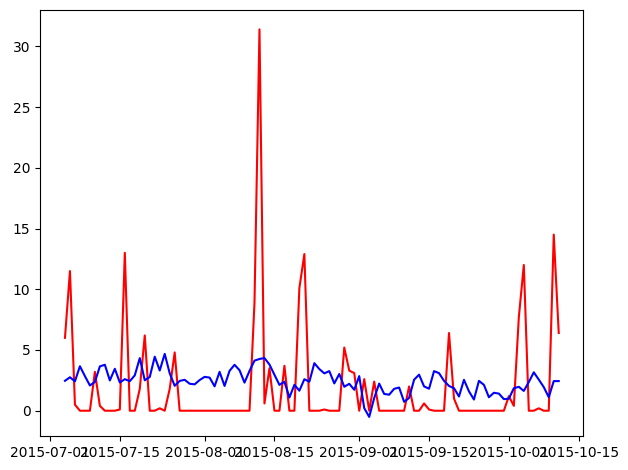

In [ ]:
plt.plot(ffill_all_data_df.iloc[7000:7100].index, ffill_all_data_df['NIEDERSCHLAGSHOEHE_TARGET_TAG_3'].iloc[7000:7100], color='red')
plt.plot(ffill_all_data_df.iloc[7000:7100].index, np.append(y_hat_tr, y_hat_test)[7000:7100], color='blue')
plt.tight_layout()
plt.show()